# Matplotlib e Seaborn — Guía en Profundidade

Este caderno amplía a explicación con **sintaxe paso a paso**, opcións habituais e **exemplos detallados** para cada tipo de gráfico. Os datos son **sintéticos** para facilitar a execución sen conexión.

> Requisitos: `pip install matplotlib seaborn pandas numpy`


## Índice
1. [Datasets sintéticos e utilidades](#datasets)
2. [Matplotlib: conceptos e sintaxe base](#mpl-base)
3. [Matplotlib: personalización (liñas, marcadores, cores, lendas, anotacións)](#mpl-personal)
4. [Matplotlib: eixes, ticks, formatters, escalas e spines](#mpl-eixes)
5. [Matplotlib: tipos de gráfico con opcións](#mpl-tipos)
6. [Matplotlib: layouts e composición (subplots, GridSpec, twin axes, secondary)](#mpl-layout)
7. [Seaborn: temas, paletas e API de alto nivel](#sns-base)
8. [Seaborn: relacións, distribucións, categóricos e faceting](#sns-graficos)
9. [Seaborn + Matplotlib: integración e afinado fino](#sns-mpl)
10. [Exportación, formatos e boas prácticas](#export)
11. [Referencias e notas de datasets](#refs)


## 1. Datasets sintéticos e utilidades  {#datasets}
Xeramos tres conxuntos:
- `df_vendas`: vendas mensuais por categoría (timeseries, trend + estacionalidade + ruido).
- `df_iris_like`: inspirado no **Iris** (Fisher, 1936): 3 especies, 4 medidas.
- `df_tips_like`: inspirado en **tips** (propinas) de Seaborn.
Engadimos algunhas funcións auxiliares (ex. para formato).

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

rng = np.random.default_rng(7)

# Vendas mensuais
meses = pd.date_range('2024-01-01', '2024-12-31', freq='MS')
cats = ['Electrónica', 'Ropa', 'Alimentos']
base = {'Electrónica': 22000, 'Ropa': 13000, 'Alimentos': 16000}
reg = []
for cat in cats:
    b = base[cat]
    for i, m in enumerate(meses):
        seasonal = 1 + 0.15*np.sin(2*np.pi*(i/12))
        trend = 1 + 0.02*i
        noise = rng.normal(0, 1200)
        v = max(0, b*seasonal*trend + noise)
        reg.append((m, cat, round(v,2)))
df_vendas = pd.DataFrame(reg, columns=['mes','categoria','vendas'])

# Iris-like
clases = ['setosa','versicolor','virginica']
params = {
    'setosa':     {'mean':[5.0,3.4,1.5,0.2], 'std':[0.35,0.30,0.20,0.10]},
    'versicolor': {'mean':[5.9,2.8,4.3,1.3], 'std':[0.45,0.30,0.40,0.20]},
    'virginica':  {'mean':[6.5,3.0,5.5,2.0], 'std':[0.55,0.35,0.45,0.25]},
}
obs = []
for c in clases:
    mu = np.array(params[c]['mean']); sd = np.array(params[c]['std'])
    X = rng.normal(mu, sd, size=(50,4))
    for row in X:
        obs.append((*row, c))
df_iris_like = pd.DataFrame(obs, columns=['sepal_length','sepal_width','petal_length','petal_width','species'])

# Tips-like
n = 240
total_bill = rng.uniform(10, 60, size=n)
pct = rng.normal(0.16, 0.05, size=n).clip(0.05, 0.35)
tip = total_bill*pct + rng.normal(0, 0.5, size=n)
smoker = rng.choice(['Si','Non'], size=n, p=[0.35,0.65])
day = rng.choice(['Xov','Ven','Sáb','Dom'], size=n, p=[0.2,0.25,0.3,0.25])
time = rng.choice(['Xantar','Cea'], size=n, p=[0.45,0.55])
size = rng.integers(1,7,size=n)
sex = rng.choice(['Home','Muller'], size=n, p=[0.55,0.45])
df_tips_like = pd.DataFrame({
    'total_bill': total_bill.round(2),
    'tip': tip.round(2),
    'smoker': smoker,
    'day': day,
    'time': time,
    'size': size,
    'sex': sex
})

display(df_vendas.head(), df_iris_like.head(), df_tips_like.head())


,mes,categoria,vendas
0,2024-01-01,Electrónica,22001.48
1,2024-02-01,Electrónica,24481.49
2,2024-03-01,Electrónica,25523.23
3,2024-04-01,Electrónica,25749.29
4,2024-05-01,Electrónica,26300.91


,sepal_length,sepal_width,petal_length,petal_width,species
0,4.988617,3.665317,1.383280,0.188830,setosa
1,5.038662,3.419135,1.254989,0.207614,setosa
2,5.475588,2.935857,1.671877,0.211935,setosa
3,4.775485,4.000125,1.652452,0.080071,setosa
4,5.026081,3.573007,1.462244,0.268291,setosa


,total_bill,tip,smoker,day,time,size,sex
0,11.32,1.27,Non,Sáb,Cea,6,Muller
1,58.15,13.11,Non,Dom,Xantar,1,Muller
2,45.68,7.59,Si,Dom,Cea,3,Home
3,20.24,3.97,Non,Dom,Cea,5,Home
4,46.54,5.41,Non,Sáb,Xantar,5,Muller


## 2. Matplotlib: conceptos e sintaxe base  {#mpl-base}
**Dúas APIs**:
- `matplotlib.pyplot` (*stateful*): rápido en demos/probas.
- **API OO** (orientada a obxectos): `fig, ax = plt.subplots()` e logo `ax.plot(...)`. **Recomendada** en proxectos.

**Elementos chave**:
- `Figure` (lenzo) e un ou varios `Axes` (área de debuxo). 
- Métodos de `Axes`: `plot`, `scatter`, `bar`, `hist`, `imshow`, `set_title`, `set_xlabel`…

In [ ]:
# En caso de non ter instalados os módulos necesarios.
# Reiniciar o kernel despois de instalar
!pip install matplotlib seaborn

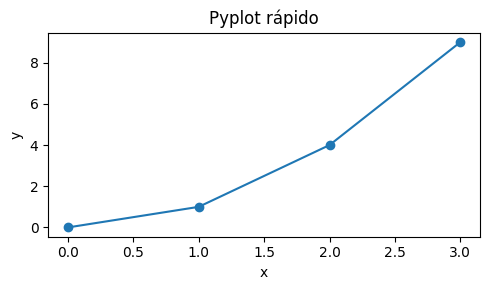

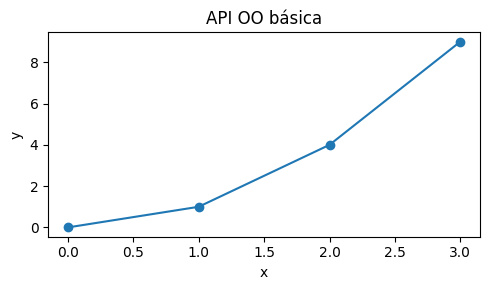

In [ ]:
# Importamos pyplot de matplotlib co alias habitual "plt"
import matplotlib.pyplot as plt

# Activamos que as gráficas se mostren incrustadas no notebook
%matplotlib inline  

# --- Uso rápido de Pyplot (estilo "procedural") ---
plt.figure(figsize=(5,3))                 # Creamos unha figura cun tamaño fixado
plt.plot([0,1,2,3], [0,1,4,9], marker='o') # Debuxamos unha liña cos puntos (0,0)-(1,1)-(2,4)-(3,9)
plt.title('Pyplot rápido')                # Título da gráfica
plt.xlabel('x'); plt.ylabel('y')          # Etiquetas dos eixes
plt.tight_layout()                        # Axusta marges para que non se solapen
plt.show()                                # Mostra a gráfica

# --- Uso da API orientada a obxectos (estilo máis "profesional") ---
fig, ax = plt.subplots(figsize=(5,3))     # Creamos a figura (fig) e un eixo (ax)
ax.plot([0,1,2,3], [0,1,4,9], marker='o') # Debuxamos a mesma liña cos puntos
ax.set(title='API OO básica',             # Definimos título e etiquetas co método .set()
       xlabel='x', ylabel='y')
fig.tight_layout()                        # Axustamos marges
plt.show()                                # Mostramos a gráfica


**Subplots básicos**: `plt.subplots(nrows, ncols, figsize, sharex, sharey)` devolve `(fig, axs)`.

In [ ]:
# Creamos unha figura con 1 fila e 2 columnas de subplots (dous eixos lado a lado)
# figsize=(8,3) define o tamaño total da figura
# sharey=True fai que os dous subplots compartan o mesmo eixe Y
fig, axs = plt.subplots(1, 2, figsize=(8,3), sharey=True)

# Filtramos os datos da categoría "Electrónica"
subE = df_vendas[df_vendas['categoria']=='Electrónica']

# Filtramos os datos da categoría "Alimentos"
subA = df_vendas[df_vendas['categoria']=='Alimentos']

# Debuxamos no primeiro subplot (axs[0]) as vendas de Electrónica
axs[0].plot(subE['mes'], subE['vendas'])
axs[0].set_title('Electrónica')  # Título específico para o primeiro subplot

# Debuxamos no segundo subplot (axs[1]) as vendas de Alimentos
axs[1].plot(subA['mes'], subA['vendas'])
axs[1].set_title('Alimentos')    # Título específico para o segundo subplot

# Para cada subplot, configuramos etiquetas comúns de eixe X e Y
for ax in axs:
    ax.set(xlabel='Mes', ylabel='€')

# Título xeral para toda a figura
fig.suptitle('Subplots con sharey=True')

# Axustamos marges e disposición para que non se solapen títulos e etiquetas
fig.tight_layout()

# Mostramos a figura
plt.show()


## 3. Matplotlib: personalización (liñas, marcadores, cores, lendas, anotacións)  {#mpl-personal}

**Liñas e marcadores** — parámetros frecuentes en `plot`:

- `linestyle` → estilo da liña.  
  - `'-'` → liña continua  
  - `'--'` → liña discontinua  
  - `'-.'` → liña punto-trazo  
  - `':'` → liña de puntos  

- `linewidth` (ou `lw`) → grosor da liña en puntos.  
  Exemplo: `linewidth=2` fai a liña máis grosa.  

- `marker` → símbolo que aparece nos puntos da serie.  
  - `'o'` → círculo  
  - `'s'` → cadrado  
  - `'^'` → triángulo cara arriba  
  - `'x'` → cruz  
  *(hai moitos máis: `'d'` rombo, `'+'` suma, etc.)*  

- `markersize` (ou `ms`) → tamaño do marcador en puntos.  
  Exemplo: `ms=8` dá marcadores máis grandes.  

- `markeredgecolor` (ou `mec`) → cor do borde do marcador.  
  Exemplo: `mec='black'`.  

- `markerfacecolor` (ou `mfc`) → cor de recheo do marcador.  
  Exemplo: `mfc='red'`.  

- `alpha` → nivel de transparencia (0 = invisible, 1 = opaco).  
  Útil cando varias liñas se solapan.  

- `zorder` → orde de debuxo (que queda “por riba” no gráfico).  
  Un valor maior fai que a liña/marcador apareza diante dos demais.  

- `label` → texto asociado á serie, que logo se amosa na lenda (`ax.legend()`).  
  Exemplo: `label='Serie A'`.  


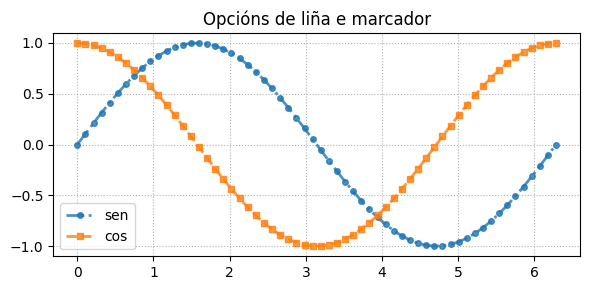

In [26]:
# Creamos un conxunto de puntos entre 0 e 2π (60 valores igualmente espaciados)
x = np.linspace(0, 2*np.pi, 60)

# Calculamos o seno e o coseno deses puntos
y1 = np.sin(x)
y2 = np.cos(x)

# Creamos a figura e un eixe (ax) cun tamaño específico
fig, ax = plt.subplots(figsize=(6,3))

# Debuxamos a curva do seno con opcións de estilo:
# - liña continua ('-'), grosor 2
# - marcador 'o' (círculo), tamaño 4
# - transparencia alpha=0.8
# - etiqueta para a lenda: 'sen'
ax.plot(x, y1, label='sen',
        linestyle='-.', linewidth=2,
        marker='o', markersize=4,
        alpha=0.8)

# Debuxamos a curva do coseno con estilo distinto:
# - liña discontinua ('--'), grosor 2
# - marcador cadrado ('s'), tamaño 4
# - transparencia alpha=0.8
# - etiqueta para a lenda: 'cos'
ax.plot(x, y2, label='cos',
        linestyle='--', linewidth=2,
        marker='s', markersize=4,
        alpha=0.8)

# Poñemos un título no subplot
ax.set_title('Opcións de liña e marcador')

# Engadimos a lenda (usa os label definidos en ax.plot)
ax.legend()

# Engadimos unha grella lixeira, con liñas de estilo punteado (':')
ax.grid(True, linestyle=':')

# Axustamos os marges da figura
fig.tight_layout()

# Amosamos a gráfica
plt.show()


**Lendas (`legend`)** — opcións frecuentes para personalizar a lenda dun gráfico:

- **Posición: `loc`** → controla onde aparece a lenda dentro do eixe.  
  Valores máis usados:  
  - `'best'` → elixe automaticamente a mellor posición sen tapar datos.  
  - `'upper right'`, `'upper left'`, `'lower right'`, `'lower left'` → esquina superior/inferior dereita ou esquerda.  
  - `'center'`, `'center left'`, `'center right'`, `'upper center'`, `'lower center'` → posicións centradas.  
  *(pódese usar número enteiro tamén: 0=best, 1=upper right, 2=upper left...)*  

- **Columnas: `ncol`** → número de columnas na lenda.  
  - `ncol=1` → a lenda aparece como lista vertical (valor por defecto).  
  - `ncol=3` → reparte os elementos en 3 columnas, útil para moitas series.  
  - `ncol=len(labels)` → forza a lenda a ser unha soa fila horizontal.  

- **Caixa arredor da lenda: `frameon`** → controla se se debuxa un recadro.  
  - `frameon=True` → engade un marco arredor da lenda.  
  - `frameon=False` → lenda sen marco (aparece só o texto).  

- **Ancoraxe externa: `bbox_to_anchor`** → permite mover a lenda fóra ou dentro do eixe.  
  - Recibe coordenadas relativas `(x, y)`.  
  - Exemplo: `bbox_to_anchor=(1,1)` coloca a lenda xusto fóra á dereita da gráfica.  
  - Combinado con `loc`, podes afinar a posición exacta.  
  - Exemplo práctico:  
    ```python
    ax.legend(loc='upper left', bbox_to_anchor=(0,1.15))
    ```
    Isto move a lenda por riba do eixe, ideal para poñela horizontal (xunto con `ncol`).


In [ ]:
# Creamos unha figura cun único eixe (ax) e tamaño 6x3
fig, ax = plt.subplots(figsize=(6,3))

# Debuxamos as series de vendas para cada categoría
for cat in ['Electrónica','Ropa','Alimentos']:
    # Filtramos o subconxunto de datos da categoría actual
    sub = df_vendas[df_vendas['categoria']==cat]
    # Debuxamos as vendas desa categoría e engadimos etiqueta para a lenda
    ax.plot(sub['mes'], sub['vendas'], label=cat)

# Engadimos a lenda (legend) coas seguintes opcións:
# - loc='upper left' → coloca a lenda no ángulo superior esquerdo da caixa de referencia
# - ncol=3 → distribúe a lenda en 3 columnas (en vez de unha soa columna vertical)
# - frameon=True → amosa un cadro arredor da lenda
# - bbox_to_anchor=(0,1.15) → despraza a lenda respecto ao gráfico
#   neste caso, comeza no punto (x=0, y=1.15) relativo á área de eixos
ax.legend(loc='upper left', ncol=3, frameon=True, bbox_to_anchor=(0,1.15))

# Poñemos título ao gráfico
ax.set_title('Lenda con ncol e bbox_to_anchor')

# Rotamos/axustamos automaticamente as etiquetas do eixe X (meses)
fig.autofmt_xdate()

# Axustamos os marges da figura
fig.tight_layout()

# Amosamos o gráfico
plt.show()


**Anotacións (`annotate`)** — permiten engadir texto e frechas que sinalan puntos concretos da gráfica.

- **Sintaxe principal**
```python
ax.annotate(
    "texto a mostrar",           # o texto da anotación
    xy=(x, y),                   # punto de referencia no gráfico
    xytext=(x_text, y_text),     # posición onde aparece o texto
    arrowprops={...}             # propiedades da frecha (opcional)
)
```

  - `xy=(x,y)` → coordenadas do punto que queremos destacar.  
  - `xytext=(x_text,y_text)` → lugar onde colocamos a caixa de texto.  
  - Se non poñemos `xytext`, o texto aparece xusto enriba do punto `xy`.  

- **Parámetro `arrowprops`**: Un dicionario con opcións de estilo da frecha que conecta o texto co punto.  

  - `arrowstyle` → forma da frecha. Exemplos:  
    - `'-'` → simple liña  
    - `'->'` → liña con punta de frecha  
    - `'-|>'` → frecha con cabeza triangular  
    - `'fancy'`, `'wedge'` → estilos decorativos  

  - `connectionstyle` → define a curva que une texto e punto. Exemplos:  
    - `'arc3'` (por defecto, curva suave)  
    - `'angle'` ou `'angle3'` (liñas en ángulo recto ou combinado)  
    - `'bar'` (liña en forma de barra)  

- **Outros parámetros útiles**
  - `fontsize`, `color` → tamaño e cor do texto.  
  - `bbox` → engade unha caixa arredor do texto, por exemplo:  
  ```python
  bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3)
  ```  
  - `ha` / `va` (`horizontalalignment` / `verticalalignment`) → aliñación horizontal/vertical do texto.  



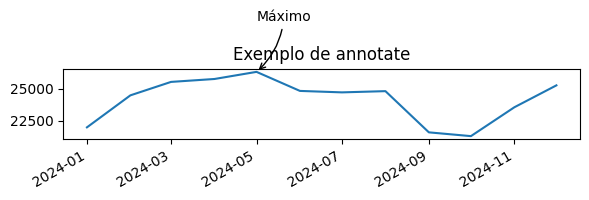

In [37]:
# Creamos unha figura cun único eixe (ax) e tamaño 6x3
fig, ax = plt.subplots(figsize=(6,3))

# Filtramos os datos só para a categoría "Electrónica"
sub = df_vendas[df_vendas['categoria']=='Electrónica']

# Debuxamos a serie de vendas mensuais de Electrónica
ax.plot(sub['mes'], sub['vendas'])

# Buscamos o índice da fila co valor máximo de vendas
imax = sub['vendas'].idxmax()

# Recuperamos esa fila (contén o mes e o valor correspondente)
fila = sub.loc[imax]

# Engadimos unha anotación para marcar o máximo
ax.annotate(
    'Máximo',                                   # texto da anotación
    xy=(fila['mes'], fila['vendas']),           # punto a destacar (máximo)
    xytext=(fila['mes'], fila['vendas']*1.15),  # posición do texto algo por riba do punto
    arrowprops=dict(                           # estilo da frecha
        arrowstyle='->',                        # frecha simple
        connectionstyle='arc3,rad=-0.2'         # liña curva cunha lixeira desviación
    )
)

# Poñemos título ao gráfico
ax.set_title('Exemplo de annotate')

# Formateamos automaticamente as etiquetas do eixe X (datas/meses)
fig.autofmt_xdate()

# Axustamos marges da figura para que non se solapen elementos
fig.tight_layout()

# Amosamos o gráfico final
plt.show()


**Cores e colormaps**

- **Ciclo de cores por defecto** → Matplotlib aplica automaticamente unha secuencia de cores definida en `rcParams`.  
  Esta secuencia repítese se hai máis series que cores dispoñibles.  
  Pódese cambiar o ciclo por defecto para empregar unha paleta personalizada.  

- **Paletas predefinidas (`colormaps`)** → ademais do ciclo, podemos empregar mapas de cores dispoñibles en Matplotlib, accesíbeis como `plt.cm.<nome>`.  
  Algúns nomes comúns: `viridis`, `plasma`, `inferno`, `magma`, `cividis`, `coolwarm`.  
  Hai colormaps **secuenciais** (para datos de menor a maior), **divergentes** (para resaltar extremos positivos e negativos) e **cualitativos** (para categorías).  

- **Uso en gráficos de dispersión (`scatter`)** → os parámetros `c` (valores a codificar) e `cmap` (mapa de cores escollido) permiten representar magnitudes mediante cor.  
  Isto engade unha dimensión visual adicional moi útil en datos continuos.  

- **Colorbar** → ao empregar un colormap con valores, é habitual engadir unha barra de cor (`colorbar`) que serve como lenda, indicando a correspondencia entre valores numéricos e cores.  


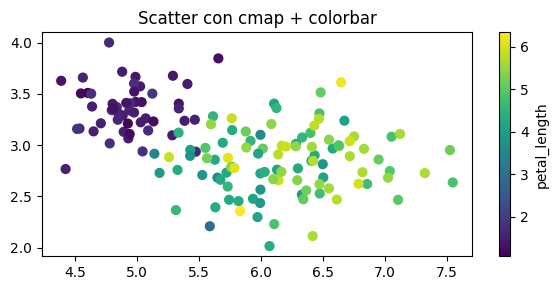

In [45]:
# Gardamos nun array os valores de "petal_length" (pétalo) para codificalos en cor
val = df_iris_like['petal_length'].values

# Creamos unha figura cun eixo (ax) e tamaño 6x3
fig, ax = plt.subplots(figsize=(6,3))

# Debuxamos un diagrama de dispersión:
# - eixe X: sepal_length (lonxitude do sépalo)
# - eixe Y: sepal_width (anchura do sépalo)
# - c=val → asignamos a cor de cada punto segundo o valor de petal_length
# - cmap='viridis' → escollemos o mapa de cores "viridis" (secuencial, moi usado)
# - s=40 → tamaño dos marcadores
sc = ax.scatter(df_iris_like['sepal_length'],
                df_iris_like['sepal_width'],
                c=val, cmap='viridis', s=40)

# Engadimos unha barra de cores asociada ao scatter (colorbar)
cb = fig.colorbar(sc, ax=ax)

# Poñemos etiqueta á barra de cores para que quede clara a variable representada
cb.set_label('petal_length')

# Título do gráfico
ax.set_title('Scatter con cmap + colorbar')

# Axustamos marges da figura
fig.tight_layout()

# Amosamos o gráfico final
plt.show()


## 4. Matplotlib: eixes, ticks, formatters, escalas e spines  {#mpl-eixes}

- **Límites e escala dos eixes**  
  - `set_xlim`, `set_ylim` → definen manualmente os límites do eixe X e Y.  
  - `set_xscale('log')`, `set_yscale('log')` → permiten cambiar a escala dun eixe (por exemplo, de lineal a logarítmica).  
  - Tamén existen escalas especiais como `'symlog'` (log simétrica arredor do 0) ou `'logit'`.  

- **Ticks (marcas nos eixes)**  
  - `set_xticks`, `set_yticks` → establecen manualmente onde se colocan as marcas (valores numéricos).  
  - `set_xticklabels`, `set_yticklabels` → definen as etiquetas mostradas nesas marcas (podemos poñer texto personalizado).  
  - `tick_params` → permite axustar estilo das marcas e etiquetas (tamaño da fonte, ángulo/rotación, cor, posición dentro/fora, etc.).  

- **Formatters e Locators (formato automático de ticks)**  
  - O módulo `matplotlib.ticker` ofrece ferramentas para personalizar como se amosan os ticks.  
  - **Formatters** → controlan o formato textual das etiquetas:  
    - `StrMethodFormatter("{x:.1f}")` → usa formato estilo `str.format`.  
    - `FuncFormatter(func)` → aplica unha función personalizada a cada valor.  
  - **Locators** → controlan a posición dos ticks:  
    - `MultipleLocator(base)` → coloca ticks en múltiplos dun valor fixo.  
    - `AutoLocator`, `MaxNLocator` → deciden automaticamente a mellor separación segundo os datos.  

- **Spines (bordes do eixe)**  
  - Son as liñas que forman o marco da área de debuxo (superior, inferior, dereita, esquerda).  
  - Pódense ocultar: por exemplo, `ax.spines['top'].set_visible(False)` elimina o borde superior.  
  - Pódense mover: `ax.spines['left'].set_position(('outward', 10))` despraza o eixe cara fóra.  
  - Útil para crear gráficos máis limpos ou con estilo minimalista (p.ex. ocultando os spines dereito e superior).  


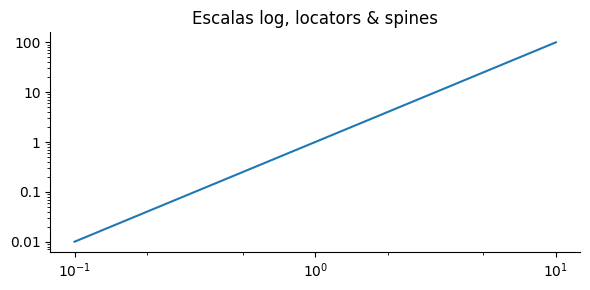

In [46]:
import matplotlib.ticker as mticker

# Creamos datos de exemplo:
# - x vai de 0.1 a 10 en 100 puntos
# - y = x^2 (función cuadrática)
x = np.linspace(0.1, 10, 100)
y = x**2

# Creamos a figura e un eixe
fig, ax = plt.subplots(figsize=(6,3))

# Debuxamos a curva
ax.plot(x, y)

# Poñemos escala logarítmica en ambos eixes
ax.set_xscale('log')
ax.set_yscale('log')

# Locator para os ticks principais do eixo X (potencias de 10)
ax.xaxis.set_major_locator(mticker.LogLocator(base=10))

# Locator para os ticks menores do eixo X (en 1, 2 e 5 dentro de cada década)
ax.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs=[1,2,5]))

# Formatter para o eixo Y: amosa os valores con formato simple (sen notación científica rara)
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:g}'))

# Quitamos os bordes superior e dereito para un estilo máis limpo
for spine in ['top','right']:
    ax.spines[spine].set_visible(False)

# Título do gráfico
ax.set_title('Escalas log, locators & spines')

# Axustamos os marges da figura
fig.tight_layout()

# Amosamos a figura
plt.show()



## 5. Matplotlib: tipos de gráfico con opcións  {#mpl-tipos}

### 5.1. Gráficos de liña (`plot`)

Son o tipo máis básico en Matplotlib, empregados para visualizar series temporais, funcións matemáticas ou calquera variable continua.

**Opcións principais:**

- **Estilo da liña (`linestyle` ou `ls`)**  
  Controla o trazo da liña:  
  - `'-'` → continua  
  - `'--'` → discontinua  
  - `'-.'` → punto-trazo  
  - `':'` → punteada  

- **Grosor da liña (`linewidth` ou `lw`)**  
  Indica o ancho da liña en puntos.  
  Exemplos: `lw=1` (fina), `lw=3` (máis grosa).  

- **Marcadores (`marker`)**  
  Símbolos que aparecen en cada punto de datos.  
  Exemplos: `'o'` (círculo), `'s'` (cadrado), `'^'` (triángulo), `'x'` (cruz).  
  Complementado con:
  - `markersize` (ou `ms`) → tamaño do marcador.  
  - `markeredgecolor` (ou `mec`) → cor do borde.  
  - `markerfacecolor` (ou `mfc`) → cor de recheo.  

- **Área baixo a curva (`fill_between`)**  
  Permite sombrear a área comprendida entre a liña e un valor de referencia (ou entre dúas series).  
  Moi útil para visualizar intervalos de confianza, áreas acumuladas ou resaltado de zonas.  

- **Debuxo escalonado (`step`)**  
  Variante de `plot` que debuxa liñas en forma de escaleira (mantén valores constantes ata o seguinte punto).  
  Útil para datos discretos, histogramas acumulados ou procesos por tramos.  


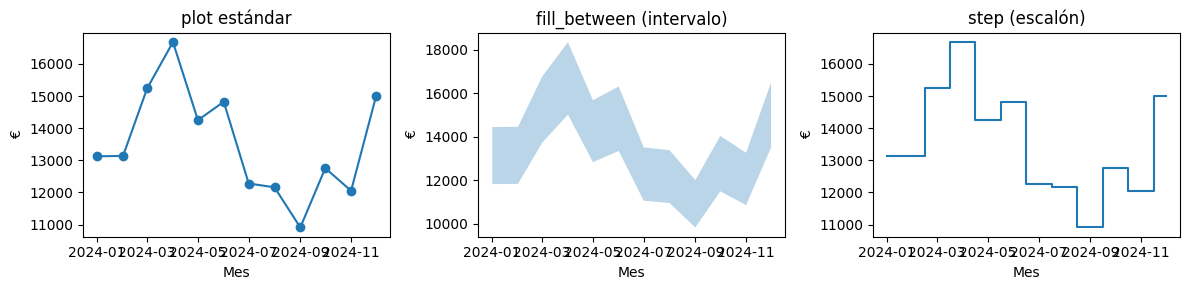

In [48]:
# Creamos un array cos índices dos meses (0,1,2,...)
x = np.arange(len(meses))

# Extraemos os valores de vendas da categoría "Ropa"
y = df_vendas[df_vendas['categoria']=='Ropa']['vendas'].values

# Creamos unha figura con 1 fila e 3 subplots en paralelo (3 gráficas)
fig, axs = plt.subplots(1,3, figsize=(12,3))

# --- 1º subplot: plot estándar ---
# Debuxamos unha liña continua cos puntos marcados con círculos
axs[0].plot(meses, y, linestyle='-', marker='o')
axs[0].set_title('plot estándar')

# --- 2º subplot: fill_between ---
# Debuxamos unha área sombreada entre o 90% e o 110% das vendas
# (intervalo ao redor da serie orixinal)
axs[1].fill_between(meses, y*0.9, y*1.1, alpha=0.3)
axs[1].set_title('fill_between (intervalo)')

# --- 3º subplot: step ---
# Debuxamos unha liña escalonada (mantén o valor ata o seguinte punto)
# where='mid' fai que o salto se produza no medio entre dous puntos
axs[2].step(meses, y, where='mid')
axs[2].set_title('step (escalón)')

# Engadimos etiquetas comúns de eixe X e Y a cada subplot
for ax in axs:
    ax.set(xlabel='Mes', ylabel='€')

# Axustamos o espazo entre subplots
fig.tight_layout()

# Amosamos o resultado
plt.show()


### 5.2. Gráficos de dispersión (`scatter`)

Os gráficos de dispersión son fundamentais para visualizar relacións entre dúas variables, detectar patróns, correlacións ou agrupamentos.

**Parámetros e opcións principais:**

- **Tamaño dos puntos (`s`)**  
  Define o tamaño dos marcadores en puntos².  
  Pode ser un valor único (todos os puntos iguais) ou un array co tamaño de cada punto individualmente.  
  Útil para representar unha terceira variable a través do tamaño.

- **Cor (`c`)**  
  - Pode ser unha cor fixa (ex. `'red'`, `'#00ff00'`).  
  - Tamén pode ser un array numérico, que se codifica mediante un mapa de cores (`cmap`).  
  - Se son valores categóricos, pódese dar unha lista de cores personalizadas.

- **Mapa de cores (`cmap`)**  
  Aplica un colormap cando `c` é numérico.  
  Exemplos habituais: `viridis` (secuencial), `coolwarm` (diverxente), `tab10` (cualitativo).  
  Permite engadir unha dimensión visual extra segundo a magnitude dunha variable.

- **Transparencia (`alpha`)**  
  Valor entre 0 e 1 que controla a opacidade.  
  Útil para reducir a saturación visual cando hai moitos puntos solapados, permitindo ver densidades.

- **Barras de cor (`colorbar`)**  
  Cando se emprega `c` con valores numéricos, adoita engadirse unha barra lateral que amosa a correspondencia entre valores e cores.  

- **Errores (`xerr`, `yerr`)**  
  Aínda que `scatter` en si non admite directamente parámetros de erro, pódese combinar con `errorbar`.  
  Isto engade barras de erro horizontais (`xerr`) e verticais (`yerr`) aos puntos, útil para representar incertezas de medida.  

- **Estilo dos marcadores**  
  Controlable con parámetros como `marker` (`'o'`, `'s'`, `'^'`, etc.), `edgecolors` (cor do bordo), `linewidths` (grosor do bordo).  
  Permite diferenciar categorías ou destacar grupos dentro do mesmo gráfico.  

En resumo, `scatter` pode representar ata **cinco dimensións de datos ao mesmo tempo**:  
- Eixe X  
- Eixe Y  
- Tamaño do punto  
- Cor do punto (segundo valor numérico ou categoría)  
- Transparencia (densidade visual)  


In [ ]:
np.random.seed(0)
x = df_iris_like['sepal_length']
y = df_iris_like['petal_length']
sizes = 20 + 80*(df_iris_like['sepal_width']-df_iris_like['sepal_width'].min())/(
                 df_iris_like['sepal_width'].max()-df_iris_like['sepal_width'].min())
fig, ax = plt.subplots(figsize=(6,3))
sc = ax.scatter(x, y, s=sizes, c=df_iris_like['petal_width'], cmap='plasma', alpha=0.8, edgecolors='none')
fig.colorbar(sc, ax=ax, label='petal_width')
ax.set_title('Scatter con tamaño e cor codificados'); ax.set(xlabel='sepal_length', ylabel='petal_length')
fig.tight_layout(); plt.show()


### 5.3. Gráficos de barras (`bar`, `barh`)

Os gráficos de barras permiten comparar valores entre categorías. Poden ser verticais (`bar`) ou horizontais (`barh`).

**Parámetros e opcións principais:**

- **Altura/longura das barras (`height` en `bar`, `width` en `barh`)**  
  - Define o valor que representa cada barra (normalmente a magnitude a comparar).  
  - En `bar`, cada barra sobe desde o eixo X.  
  - En `barh`, cada barra esténdese cara a dereita/esquerda dende o eixo Y.  

- **Ancho das barras (`width` en `bar`, `height` en `barh`)**  
  - Controla o grosor das barras.  
  - Por defecto é 0.8 (barra case pegada á seguinte).  
  - Valores máis baixos deixan espazo entre barras (p.ex. `width=0.5`).  

- **Posición/separación**  
  - O argumento `x` (ou `y` en `barh`) indica a posición central de cada barra.  
  - Para gráficos con varias series lado a lado, desplázanse as posicións das barras de cada grupo para que non se solapen.  
  - Permite representar comparativas entre categorías ao longo dun mesmo eixo.  

- **Barras apiladas (`stacked`)**  
  - Usando varios chamamentos a `bar` co mesmo `x`, pódense apilar valores sumando as alturas.  
  - Útil para ver composición total dunha categoría e as súas partes.  

- **Barras con erros (`yerr`, `xerr`)**  
  - Admiten barras de erro verticais (`yerr` en `bar`) ou horizontais (`xerr` en `barh`).  
  - Representan a variabilidade ou incerteza asociada a cada medida.  
  - Pódese configurar estilo das barras de erro con `capsize`, `elinewidth`, etc.  

- **Orientación (`bar` vs `barh`)**  
  - `bar` → barras verticais (categorías no eixo X, valores no eixo Y).  
  - `barh` → barras horizontais (categorías no eixo Y, valores no eixo X).  
  - A versión horizontal mellora a lectura cando hai moitas categorías ou etiquetas longas.  

- **Estilo das barras**  
  - `color` / `facecolor` → cor de recheo.  
  - `edgecolor` → cor do bordo.  
  - `linewidth` → grosor do bordo.  
  - `alpha` → transparencia.  
  - `hatch` → patróns de recheo (listras, puntos, etc.), útil para impresión en branco e negro.  

- **Etiquetas e anotacións**  
  - É habitual engadir os valores numéricos enriba (ou ao lado) das barras para facilitar a lectura.  
  - Pódese facer con bucles sobre os obxectos devoltos por `bar`/`barh` e chamando a `ax.text()`.  

En resumo, os gráficos de barras son moi versátiles:  
- Permiten comparar categorías de forma sinxela.  
- Pódense orientar en vertical ou horizontal.  
- Admiten opcións de estilo, apilado e barras de erro.  
- Resultan moi útiles para resumos estatísticos e presentación de resultados.  



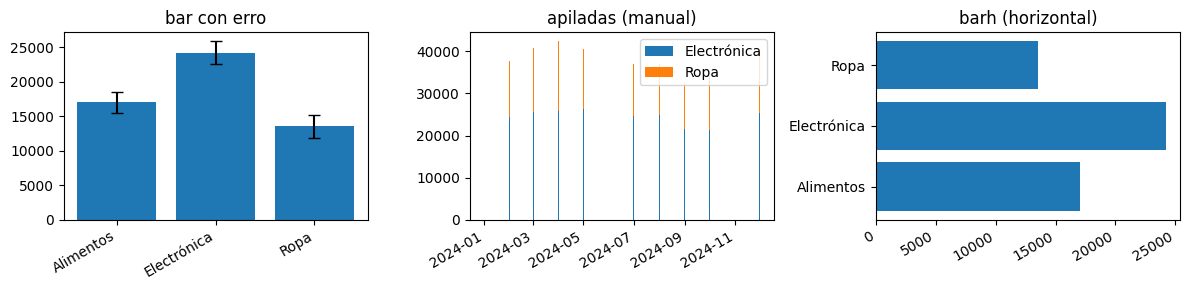

In [76]:
# Calculamos a media de vendas por categoría
media = df_vendas.groupby('categoria')['vendas'].mean()

# Calculamos a desviación estándar (para usar como erro)
std = df_vendas.groupby('categoria')['vendas'].std()

# Creamos unha figura con 3 subplots en fila
fig, axs = plt.subplots(1,3, figsize=(12,3))

# --- 1º subplot: barras con erro ---
# Debuxamos a media de cada categoría en barras verticais
# yerr=std.values → engadimos barras de erro coa desviación estándar
# capsize=4 → tamaño das "tapas" das barras de erro
axs[0].bar(media.index, media.values, yerr=std.values, capsize=4)
axs[0].set_title('bar con erro')

# --- 2º subplot: barras apiladas (feito manualmente) ---
# Facemos unha táboa pivote coas vendas por mes e categoría
pivot = df_vendas.pivot(index='mes', columns='categoria', values='vendas')

# Debuxamos primeiro as barras de Electrónica
axs[1].bar(pivot.index, pivot['Electrónica'], label='Electrónica')

# Debuxamos as barras de Ropa "apiladas" sobre Electrónica (bottom=...)
axs[1].bar(pivot.index, pivot['Ropa'], bottom=pivot['Electrónica'], label='Ropa')

# Poñemos título e engadimos lenda para identificar as categorías
axs[1].set_title('apiladas (manual)')
axs[1].legend()

# --- 3º subplot: barras horizontais ---
# Representamos a media de vendas por categoría en barras horizontais
axs[2].barh(media.index, media.values)
axs[2].set_title('barh (horizontal)')

# Rotamos etiquetas do eixo X para mellorar a lectura en subplots con datas
fig.autofmt_xdate()

# Axustamos os marges e separacións
fig.tight_layout()

# Amosamos a figura
plt.show()


### 5.4. Histogramas (`hist`)

Os histogramas representan a distribución dunha variable continua, agrupando os valores en intervalos (bins) e contando a frecuencia de observacións en cada un deles.

**Parámetros e opcións principais:**

- **Número de intervalos (`bins`)**  
  - Controla cantas divisións se crean no rango de valores.  
  - Pode ser un número enteiro (ex. `bins=20`) ou unha lista de bordes definidos manualmente.  
  - Máis bins → maior detalle pero máis ruído; menos bins → máis xeralización.  

- **Rango (`range`)**  
  - Define o intervalo de valores que se inclúe no histograma.  
  - Exemplo: `range=(0,100)` limita a ese intervalo, ignorando valores fóra.  
  - Útil cando queremos centrarnos nun subconxunto de datos.  

- **Normalización (`density`)**  
  - Se `density=True`, o histograma amosa densidades de probabilidade en vez de frecuencias absolutas.  
  - A área baixo a curva resultante é 1.  
  - Útil para comparar distribucións con distintos tamaños de mostra.  

- **Apilamento (`stacked`)**  
  - Cando hai varias series, `stacked=True` apílaas vertical ou horizontalmente, mostrando a suma acumulada.  
  - Permite comparar distribucións por grupos mantendo o total.  

- **Orientación**  
  - Por defecto, as barras son verticais.  
  - Con `orientation='horizontal'`, as barras debúxanse de esquerda a dereita.  
  - A versión horizontal é útil cando hai etiquetas ou categorías que encaixan mellor no eixo vertical.  

- **Estilo adicional**  
  - `color`, `edgecolor` → personalizan o recheo e bordo das barras.  
  - `alpha` → define transparencia, útil para superpoñer varias distribucións.  
  - `histtype` → estilo de representación (`'bar'`, `'step'`, `'stepfilled'`), permite variacións na visualización.  

En resumo, os histogramas son unha ferramenta esencial para **explorar a forma dunha distribución** (asimetría, curtose, multimodalidade) e comparar grupos de datos de maneira clara.  


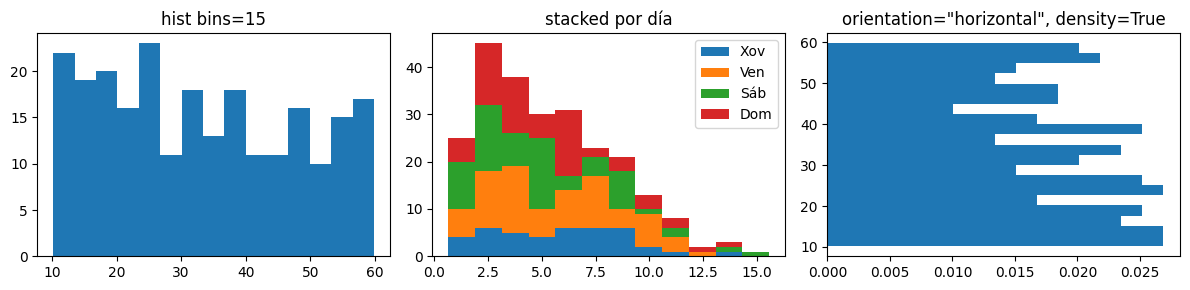

In [82]:
# Creamos unha figura con 3 subplots en fila (1x3), tamaño total 12x3
fig, axs = plt.subplots(1,3, figsize=(12,3))

# --- 1º subplot: histograma simple ---
# Histograma da variable 'total_bill' con 15 intervalos (bins)
# density=False → amósanse as frecuencias absolutas (número de observacións en cada bin)
axs[0].hist(df_tips_like['total_bill'], bins=15, density=False)
axs[0].set_title('hist bins=15')

# --- 2º subplot: histogramas apilados ---
# Construímos unha lista de series, unha por cada día ['Xov','Ven','Sáb','Dom']
# Cada lista contén os valores da columna 'tip' dese día
axs[1].hist([df_tips_like[df_tips_like['day']==d]['tip'] for d in ['Xov','Ven','Sáb','Dom']],
            bins=12, stacked=True,    # apilamos os histogramas para ver composición
            label=['Xov','Ven','Sáb','Dom'])
axs[1].legend()
axs[1].set_title('stacked por día')

# --- 3º subplot: histograma horizontal ---
# Histograma de 'total_bill' con 20 bins
# orientation='horizontal' → barras en horizontal
# density=True → normalizamos para que a área total sexa 1 (densidade de probabilidade)
axs[2].hist(df_tips_like['total_bill'], bins=20, orientation='horizontal', density=True)
axs[2].set_title('orientation="horizontal", density=True')

# Axustamos os marges para que os títulos e eixes non se solapen
fig.tight_layout()

# Amosamos a figura completa
plt.show()



### 5.5. Boxplot / Violin / ECDF básicos con Matplotlib puro

Estes gráficos permiten explorar a distribución dunha variable e comparar grupos.

- **Boxplot (`boxplot`)**  
  - Resume a distribución dunha variable a través de cinco números: mínimo, 1º cuartil, mediana, 3º cuartil e máximo.  
  - Mostra tamén os *outliers* (valores extremos) como puntos fóra das “bigotes”.  
  - Parámetros clave:  
    - `vert=True/False` → orientación vertical ou horizontal.  
    - `patch_artist=True` → permite personalizar o recheo da caixa (cor, transparencia).  
    - `showmeans=True` → engade a media como símbolo adicional.  
    - `notch=True` → mostra unha “muesca” arredor da mediana para indicar intervalos de confianza.  

- **Violin plot (`violinplot`)**  
  - Combina boxplot + estimación de densidade: mostra a distribución completa de forma simétrica arredor dun eixe.  
  - Permite ver multimodalidade ou asimetrías que non se aprecian nun boxplot.  
  - Parámetros clave:  
    - `tick_labels` → etiquetas para cada caixa.
    - `vert=True/False` → orientación.  
    - `showmeans`, `showmedians`, `showextrema` → controlan se se debuxan media, mediana e valores extremos.  
    - `bw_method` → ancho de banda para a estimación de densidade (controla suavizado).  

- **ECDF (Empirical Cumulative Distribution Function)**  
  - Non existe unha función directa en Matplotlib, pero pode debuxarse con `plot` ordenando os datos.  
  - Mostra a proporción acumulada de observacións ≤ a cada valor.  
  - Útil para comparar distribucións enteiras de forma máis clara ca cos histogramas.  
  - Opcións habituais:  
    - `marker` → engadir símbolos en cada punto da función ECDF.  
    - `linestyle` → pode ser liña continua ou escalonada para reforzar a idea acumulativa.  

**Resumo**:  
- O **boxplot** é compacto e resume ben posición e dispersión.  
- O **violin plot** engade detalle sobre a forma da distribución.  
- O **ECDF** permite comparar visualmente distribucións enteiras e ver percentís de maneira directa.  


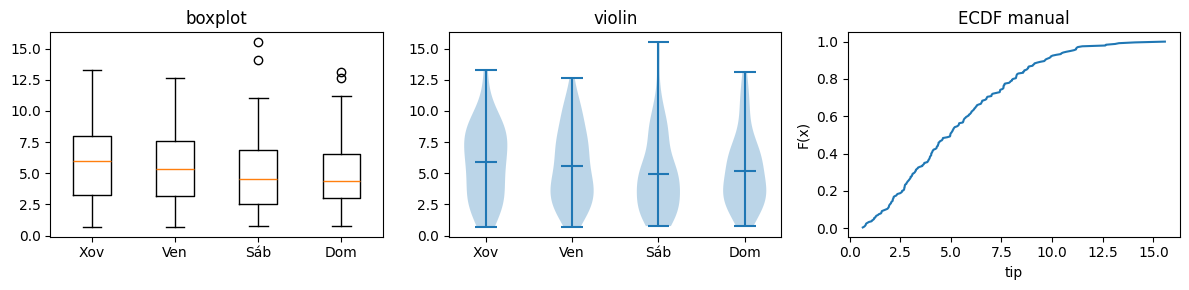

In [85]:
# Creamos unha figura con 3 subplots en fila, tamaño 12x3
fig, axs = plt.subplots(1,3, figsize=(12,3))

# Preparamos os datos: lista de arrays cos valores de 'tip' por día
grupos = [df_tips_like[df_tips_like['day']==d]['tip'] for d in ['Xov','Ven','Sáb','Dom']]

# --- 1º subplot: boxplot ---
# Debuxamos boxplots cos catro grupos (un por día)
# tick_labels → nomes baixo cada caixa
axs[0].boxplot(grupos, tick_labels=['Xov','Ven','Sáb','Dom'])
axs[0].set_title('boxplot')

# --- 2º subplot: violinplot ---
# Debuxamos violin plots cos mesmos grupos
# showmeans=True → engade a media como símbolo
# showextrema=True → engade os valores mínimos e máximos
axs[1].violinplot(grupos, showmeans=True, showextrema=True)

# Poñemos as etiquetas de día nos ticks do eixo X
axs[1].set_xticks(range(1,5))
axs[1].set_xticklabels(['Xov','Ven','Sáb','Dom'])
axs[1].set_title('violin')

# --- 3º subplot: ECDF (función de distribución acumulada empírica) ---
# Ordenamos os valores de 'tip'
arr = np.sort(df_tips_like['tip'].values)

# Calculamos a proporción acumulada (1/n, 2/n, ..., n/n)
ecdf_y = np.arange(1, len(arr)+1)/len(arr)

# Debuxamos a curva ECDF
axs[2].plot(arr, ecdf_y)
axs[2].set_title('ECDF manual')
axs[2].set_xlabel('tip')
axs[2].set_ylabel('F(x)')

# Axustamos o espazo entre subplots
fig.tight_layout()

# Amosamos a figura
plt.show()


### 5.6. Imágenes / matrices (`imshow`) e mapas de calor con `pcolor` / `imshow`

Matplotlib permite representar datos bidimensionais como imaxes ou mapas de calor, útiles para visualizar matrices, correlacións ou distribucións espaciais.

- **`imshow` (visualizar matrices como imaxe)**  
  - Converte un array 2D nunha imaxe.  
  - Cada celda da matriz represéntase cun pixel coloreado segundo o seu valor.  
  - Parámetros clave:  
    - `cmap` → mapa de cores empregado.  
    - `interpolation` → controla o suavizado entre píxeles (`'nearest'`, `'bilinear'`, `'bicubic'`...).  
    - `aspect` → relación de aspecto (`'auto'`, `'equal'`).  
    - `origin` → posición da orixe: `'upper'` (arriba esquerda, por defecto) ou `'lower'`.  
  - Útil para visualizar imaxes, datos de sensores, ou calquera matriz numérica.

- **`pcolor` / `pcolormesh` (mapas de calor con grella)**  
  - Representan unha grella rectangular (ou irregular no caso de `pcolor`) asignando unha cor a cada celda.  
  - A diferenza de `imshow`, poden usarse con eixes non regulares (coordenadas X/Y personalizadas).  
  - Parámetros clave:  
    - `cmap` → mapa de cores.  
    - `shading` → controla como se colorean as celas (`'auto'`, `'flat'`, `'nearest'`).  
    - Permite debuxar con valores asociados a cada rectángulo da grella.  

- **Escala de cores e barras de cor (`colorbar`)**  
  - Tanto con `imshow` como con `pcolor`, é habitual engadir unha barra de cor que mostre a correspondencia entre valores numéricos e cores.  
  - `fig.colorbar(m, ax=ax)` engade a barra ligada ao mapa de cores da imaxe/matriz.

**Resumo**  
- `imshow` → rápido e eficiente para visualizar arrays 2D como imaxes (con interpolación opcional).  
- `pcolor` / `pcolormesh` → máis flexibles para grellas con coordenadas personalizadas ou non uniformes.  
- Os mapas de calor son moi útiles para visualizar correlacións, matrices de confusión, intensidades ou calquera dato 2D.  


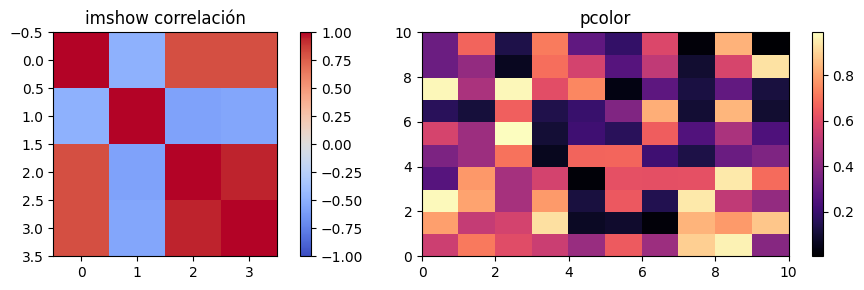

In [86]:
# Calculamos a matriz de correlación das variables numéricas do dataset iris_like
corr = df_iris_like.drop(columns=['species']).corr(numeric_only=True)

# Creamos unha figura con 2 subplots en fila
fig, axs = plt.subplots(1,2, figsize=(10,3))

# --- 1º subplot: imshow ---
# Representamos a matriz de correlación como imaxe
# cmap='coolwarm' → colormap diverxente (cores frías/negativas a quentes/positivas)
# vmin=-1, vmax=1 → fixamos o rango da escala de cor (de -1 a 1, valores posibles de correlación)
im = axs[0].imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
axs[0].set_title('imshow correlación')
# Engadimos unha barra de cor para interpretar os valores da correlación
fig.colorbar(im, ax=axs[0])

# --- 2º subplot: pcolor ---
# Xeramos unha matriz aleatoria 10x10
X = np.random.RandomState(0).rand(10, 10)

# Debuxamos a grella con pcolor, asignando cor a cada celda segundo o valor
c = axs[1].pcolor(X, cmap='magma')
axs[1].set_title('pcolor')
# Engadimos a súa barra de cor
fig.colorbar(c, ax=axs[1])

# Axustamos disposición para que non se solapen elementos
fig.tight_layout()

# Amosamos a figura completa
plt.show()



## 6. Matplotlib: layouts e composición  {#mpl-layout}

**Layout (organización de subplots)**  
- `tight_layout()` → axusta automaticamente espazos entre subplots, evitando que títulos ou etiquetas se solapen.  
- `constrained_layout=True` en `plt.subplots` → alternativa máis moderna, que optimiza a disposición tendo en conta títulos, etiquetas e colorbars.  
- `GridSpec` → ferramenta para crear disposicións complexas (subplots de diferentes tamaños e posicións dentro da grella).  
  - Permite, por exemplo, un subplot grande á esquerda e dous máis pequenos á dereita.  
  - Útil cando se precisa máis control que co `plt.subplots` estándar.  

**Dous eixes compartidos**  
- `twinx()` → crea un segundo eixo Y compartindo o mesmo eixo X.  
  - Útil cando dúas variables teñen diferente escala pero comparten o mesmo eixo temporal/categórico.  
- `twiny()` → crea un segundo eixo X compartindo o mesmo eixo Y.  
  - Útil para amosar dúas escalas horizontais alternativas.  
- **Secondary axis** (`secondary_xaxis`, `secondary_yaxis`) → permite engadir un segundo eixo cunha transformación matemática dos valores do primeiro.  
  - Exemplo: converter radianos en graos, Celsius en Fahrenheit, ou escala lineal en logarítmica.  
  - A transformación defínese con funcións directas e inversas.  

**Resumo**  
- Para disposicións sinxelas: usar `tight_layout()` ou `constrained_layout`.  
- Para disposicións avanzadas: usar `GridSpec`.  
- Para dúas escalas sobre o mesmo gráfico: `twinx()`/`twiny()` ou secondary axis con transformacións.  


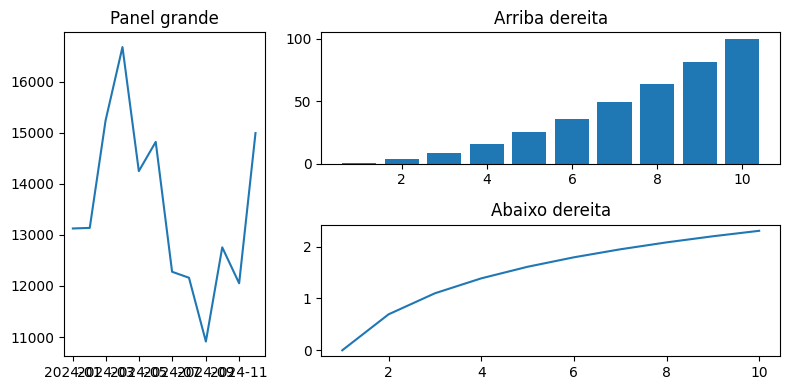

In [89]:
from matplotlib.gridspec import GridSpec

# Creamos unha figura baleira de tamaño 8x4
fig = plt.figure(figsize=(8,4))

# Definimos un GridSpec de 2 filas e 3 columnas asociado á figura
gs = GridSpec(2, 3, figure=fig)

# --- Subplots coa grella definida ---
# ax1 ocupa todas as filas (:) da primeira columna (0)
ax1 = fig.add_subplot(gs[:,0])

# ax2 ocupa a primeira fila (0) e as columnas 1 e 2
ax2 = fig.add_subplot(gs[0,1:])

# ax3 ocupa a segunda fila (1) e tamén as columnas 1 e 2
ax3 = fig.add_subplot(gs[1,1:])

# --- Panel grande á esquerda ---
# Debuxamos a serie de vendas da categoría "Ropa"
ax1.plot(df_vendas[df_vendas['categoria']=='Ropa']['mes'],
         df_vendas[df_vendas['categoria']=='Ropa']['vendas'])
ax1.set_title('Panel grande')

# --- Panel superior dereita ---
x = np.arange(1,11)
# Debuxamos un gráfico de barras cos valores de x ao cadrado
ax2.bar(x, x**2)
ax2.set_title('Arriba dereita')

# --- Panel inferior dereita ---
# Debuxamos a función logaritmo
ax3.plot(x, np.log(x))
ax3.set_title('Abaixo dereita')

# Axustamos os espazos entre subplots
fig.tight_layout()

# Amosamos a figura
plt.show()


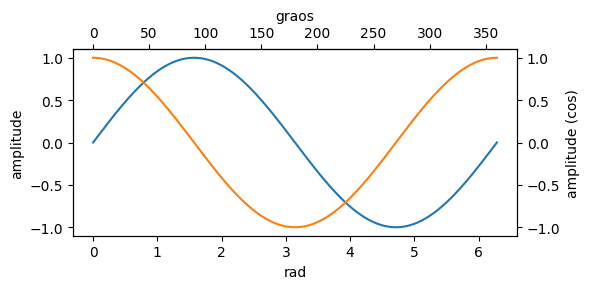

In [90]:
# Creamos unha figura cun eixo principal (ax)
fig, ax = plt.subplots(figsize=(6,3))

# Datos: 200 puntos entre 0 e 2π
x = np.linspace(0, 2*np.pi, 200)
y = np.sin(x)

# --- Eixe principal ---
# Debuxamos a función sen(x)
ax.plot(x, y, label='sen(x)')
ax.set_xlabel('rad')          # etiqueta do eixo X en radianos
ax.set_ylabel('amplitude')    # etiqueta do eixo Y

# --- Eixe secundario en Y ---
# Creamos un segundo eixo Y compartindo o mesmo eixo X
ax2 = ax.twinx()
# Debuxamos a función cos(x) neste segundo eixo
ax2.plot(x, np.cos(x), color='tab:orange', label='cos(x)')
ax2.set_ylabel('amplitude (cos)')  # etiqueta para diferenciar

# --- Eixe secundario en X ---
# Definimos funcións de conversión rad ↔ graos
def rad2deg(r): return r*180/np.pi
def deg2rad(d): return d*np.pi/180

# Creamos un segundo eixo X na parte superior
# functions=(rad2deg, deg2rad) → como converter valores de rad a graos e viceversa
secax = ax.secondary_xaxis('top', functions=(rad2deg, deg2rad))
secax.set_xlabel('graos')  # etiqueta para o novo eixo superior

# Axustamos marges
fig.tight_layout()

# Amosamos o resultado
plt.show()


## 7. Seaborn: temas, paletas e API de alto nivel  {#sns-base}

**Filosofía**  
- Seaborn é unha libraría de visualización que se constrúe sobre Matplotlib, ofrecendo unha **API de alto nivel** para gráficos estatísticos.  
- Está fortemente integrada con **pandas**: traballa directamente con `DataFrame` e nomes de columnas, evitando a manipulación manual de arrays.  
- Facilita o *faceting* (subdividir datos en múltiples paneis de forma automática) con `FacetGrid`, `catplot`, `relplot` etc.  
- Inclúe gráficos estatísticos máis elaborados de serie (regresións, distribucións, relacións entre variables).

**Temas e contextos**  
Seaborn permite configurar o estilo visual global dos gráficos cunha soa chamada:

- `sns.set_theme(style=..., context=..., palette=...)`  
  - **`style`** → define o estilo estético de base.  
    - `'darkgrid'` → grella escura (por defecto).  
    - `'whitegrid'` → grella clara, útil para gráficos con barras.  
    - `'dark'` → fondo escuro sen grella.  
    - `'white'` → fondo branco minimalista.  
    - `'ticks'` → similar a white pero con ticks máis marcados.  
  - **`context`** → axusta a escala de tamaños de texto e elementos segundo o uso.  
    - `'paper'` → tamaño reducido, pensado para artigos.  
    - `'notebook'` → tamaño intermedio, equilibrado (por defecto).  
    - `'talk'` → tamaños máis grandes, adecuado para charlas.  
    - `'poster'` → elementos moi grandes, pensados para presentacións.  
  - **`palette`** → define a paleta de cores por defecto.  
    - Pode ser o nome dunha paleta (`'deep'`, `'muted'`, `'bright'`, `'pastel'`, `'dark'`, `'colorblind'`).  
    - Tamén acepta colormaps de Matplotlib (`'viridis'`, `'coolwarm'`…), listas personalizadas de cores, ou xeradores como `sns.color_palette()`.  

**Resumo**  
- Seaborn simplifica a creación de **gráficos estatísticos atractivos e consistentes**.  
- A configuración global mediante `set_theme` garante uniformidade estética en todas as figuras.  
- Os temas e contextos permiten adaptar os gráficos a **informes escritos, cadernos de aula, presentacións ou publicacións profesionais**.  


In [91]:
try:
    import seaborn as sns
    print('Seaborn:', sns.__version__)
    sns.set_theme(style='whitegrid', context='notebook')
    # Paletas
    pal = sns.color_palette('deep')
    print('Exemplo de paleta deep:', pal[:5])
except Exception as e:
    print('Seaborn non dispoñible:', e)


Seaborn: 0.13.2
Exemplo de paleta deep: [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), (0.5058823529411764, 0.4470588235294118, 0.7019607843137254)]


## 8. Seaborn: relacións, distribucións, categóricos e faceting  {#sns-graficos}

### 8.1. Gráficos relacionais

Estes gráficos representan **relacións entre variables cuantitativas**, permitindo engadir dimensións extra mediante cor, forma ou tamaño.  
En Seaborn hai dúas funcións principais:  

- **`scatterplot`** → nube de puntos para dúas variables numéricas.  
- **`lineplot`** → liña que conecta valores, útil para series temporais ou tendencias.  
- **`relplot`** → versión de alto nivel que crea figuras completas con *faceting* (subdivisión en filas/columnas), podendo xerar múltiples `scatterplot` ou `lineplot` ao mesmo tempo.

**Parámetros principais:**

- **`hue`** → asigna unha variable a cores diferentes.  
  - Se é categórica → cada categoría recibe unha cor distinta.  
  - Se é numérica → usa un mapa de cores continuo.  
  - Útil para distinguir grupos ou codificar intensidade.

- **`style`** → asigna unha variable á forma ou estilo dos marcadores/ liñas.  
  - En `scatterplot` → cambia o tipo de marcador.  
  - En `lineplot` → cambia o estilo de liña (continua, discontinua, etc.).  
  - Axuda a diferenciar categorías mesmo en branco e negro.

- **`size`** → asigna unha variable ao tamaño dos puntos.  
  - Permite engadir unha terceira dimensión visual ao scatterplot.  
  - Pódese escalar automaticamente ou definir un rango de tamaños.  

- **`col`** e **`row`** (só en `relplot`) → fan *faceting* automático.  
  - Dividen a figura en múltiples subplots segundo valores dunha variable categórica.  
  - `col` → subdivide en columnas, `row` → en filas.  
  - Ideal para comparar distribucións ou relacións en distintos grupos dunha variable.  

**Resumo**  
- `scatterplot` e `lineplot` → gráficos básicos para relacións entre variables.  
- `relplot` → permite reproducir estes gráficos a nivel de figura completa con *faceting*.  
- Os parámetros `hue`, `style`, `size`, `col`, `row` engaden ata **cinco dimensións de información** de maneira clara e consistente.  


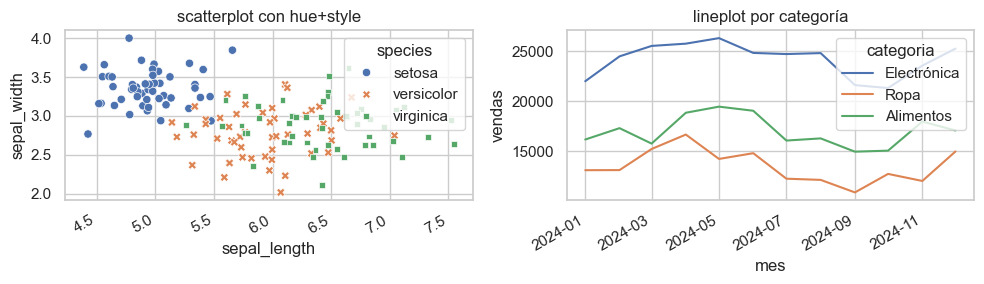

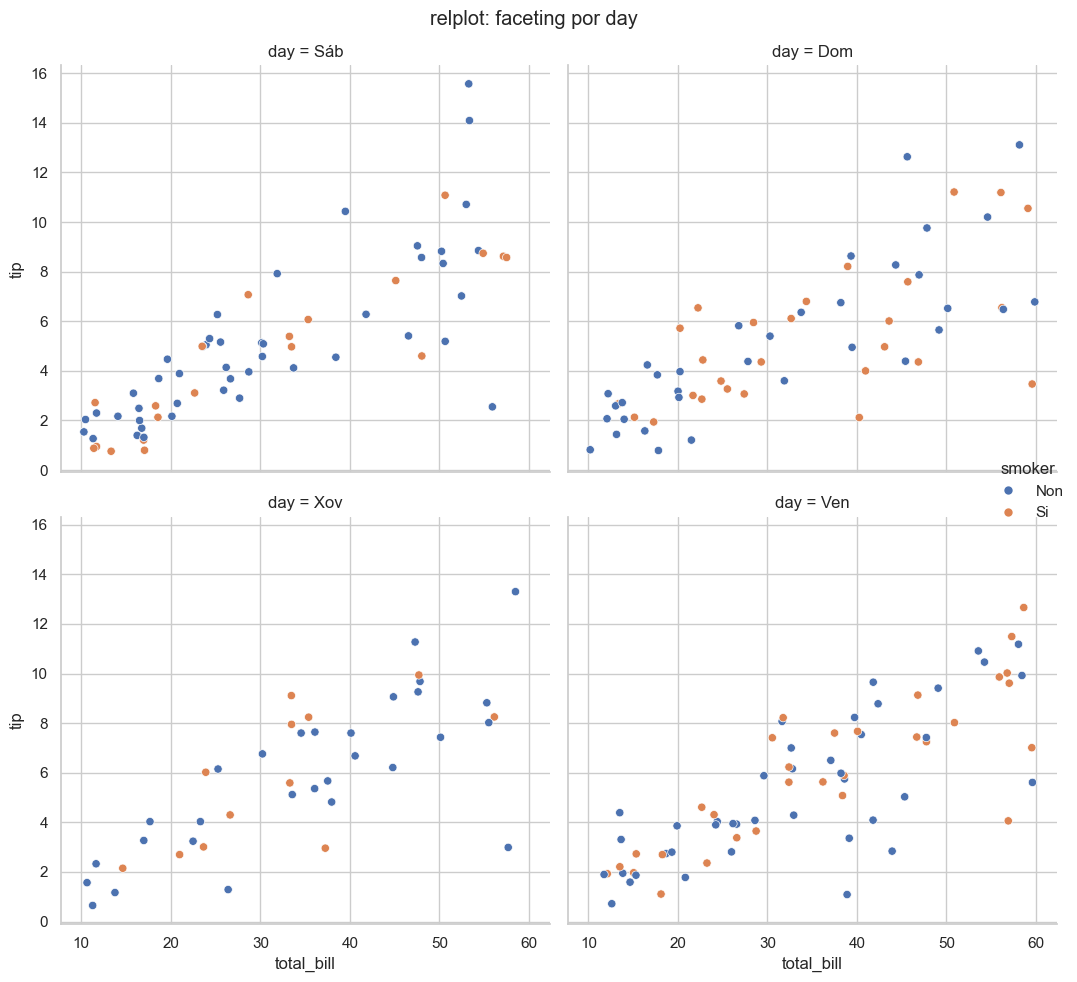

In [101]:
try:
    import seaborn as sns

    # Creamos unha figura con 2 subplots en fila
    fig, axs = plt.subplots(1,2, figsize=(10,3))

    # --- 1º subplot: scatterplot ---
    # Representamos 'sepal_length' vs 'sepal_width'
    # - hue='species' → cor distinta para cada especie
    # - style='species' → tamén cambia o marcador segundo a especie
    sns.scatterplot(
        data=df_iris_like,
        x='sepal_length', y='sepal_width',
        hue='species', style='species',
        ax=axs[0]
    )
    axs[0].set_title('scatterplot con hue+style')

    # --- 2º subplot: lineplot ---
    # Evolución das vendas por mes, diferenciando categorías por cor
    sns.lineplot(
        data=df_vendas,
        x='mes', y='vendas',
        hue='categoria',
        ax=axs[1]
    )
    axs[1].set_title('lineplot por categoría')
    fig.autofmt_xdate()  # rotación automática das etiquetas de data/mes

    # Axustamos a disposición da figura
    plt.tight_layout()
    plt.show()

    # --- Gráfico a nivel de figura con relplot ---
    # Faceting: divide a figura en varios subplots segundo 'day'
    # - hue='smoker' → cor segundo se é fumador/non
    # - col='day' → crea unha columna por día
    # - col_wrap=2 → organiza as columnas en filas de máximo 2 subplots
    g = sns.relplot(
        data=df_tips_like,
        x='total_bill', y='tip',
        hue='smoker',
        col='day',
        col_wrap=2
    )
    g.fig.suptitle('relplot: faceting por day')  # título global
    plt.tight_layout()

except Exception as e:
    print('Seaborn non dispoñible:', e)


### 8.2. Regresión e relacións avanzadas: `regplot`, `lmplot`

Seaborn ofrece funcións específicas para **gráficos de relación con axuste de regresión**, que permiten visualizar tendencias e modelos lineais ou non lineais sobre os datos.

- **`regplot`**  
  - É a función básica para representar un *scatterplot* acompañado dunha curva de regresión.  
  - Parámetros clave:  
    - `x`, `y` → variables a representar.  
    - `data` → `DataFrame` con eses datos.  
    - `order` → grao do polinomio para axustar (por defecto, recta lineal).  
    - `logx=True` → transforma o eixo X en logarítmico antes do axuste.  
    - `ci` → intervalo de confianza arredor da recta (por defecto 95%).  
    - `line_kws` → personalización da liña (cor, estilo, grosor).  
    - `scatter_kws` → personalización dos puntos (tamaño, alpha, marcador).  
  - É útil cando se quere un único gráfico detallado con control fino sobre estilo e axuste.

- **`lmplot`** (*linear model plot*)  
  - Versión de alto nivel que funciona a nivel de figura (semellante a `relplot`), baseada internamente en `regplot`.  
  - Soporta directamente *faceting* (subplots múltiples).  
  - Parámetros clave:  
    - `hue`, `col`, `row` → permiten subdividir a análise en función de variables categóricas.  
    - `scatter` / `fit_reg` → controlan se se debuxan os puntos, a recta de regresión ou ambos.  
    - `robust=True` → axuste robusto fronte a outliers.  
    - `truncate=False` → fai que a recta se debuxe en toda a extensión do eixo, non só no rango de datos.  
    - `ci` → intervalo de confianza da estimación.  
  - Ideal cando se quere comparar relacións **en distintos subgrupos** dentro da mesma figura.  

**Resumo**  
- `regplot` → gráfico puntual + regresión simple ou polinómica, pensado para análise detallada dunha relación.  
- `lmplot` → máis alto nivel, permite análises comparativas con faceting, mantendo a mesma lóxica de regresión pero integrada nunha figura multi-panel.  


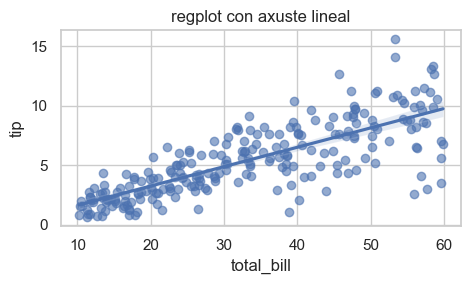

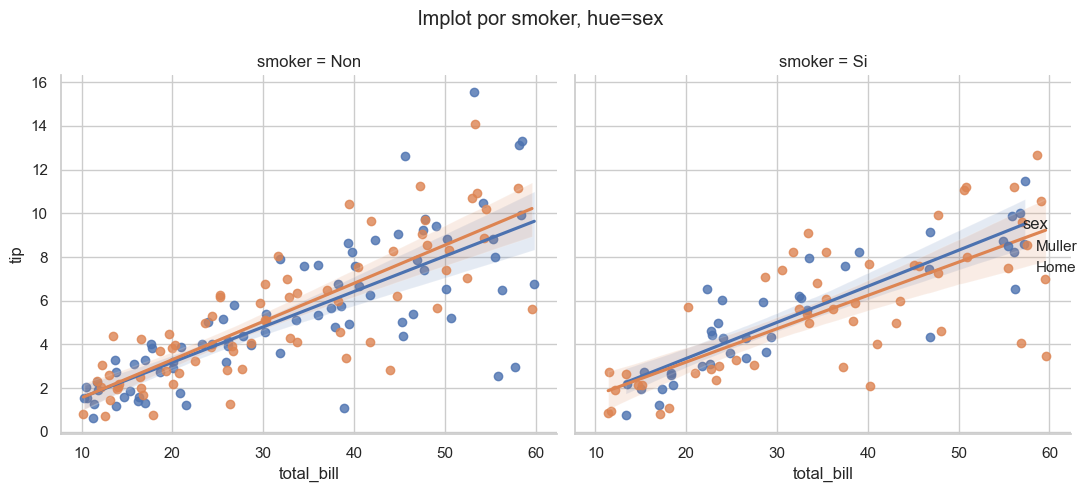

In [103]:
try:
    import seaborn as sns

    # --- regplot ---
    fig, ax = plt.subplots(figsize=(5,3))
    # Debuxamos un scatterplot de total_bill vs tip cunha recta de regresión lineal
    # scatter_kws={'alpha':0.6} → facemos os puntos un pouco transparentes para ver mellor as zonas densas
    sns.regplot(
        data=df_tips_like,
        x='total_bill', y='tip',
        ax=ax,
        scatter_kws={'alpha':0.6}
    )
    ax.set_title('regplot con axuste lineal')
    plt.tight_layout()
    plt.show()

    # --- lmplot ---
    # Versión de máis alto nivel, que xera unha figura completa con subplots
    # col='smoker' → divide en columnas segundo se a persoa é fumadora ou non
    # hue='sex' → usa cores distintas para homes/mulleres
    g = sns.lmplot(
        data=df_tips_like,
        x='total_bill', y='tip',
        col='smoker', hue='sex'
    )
    g.fig.suptitle('lmplot por smoker, hue=sex')
    plt.tight_layout()

except Exception as e:
    print('Seaborn non dispoñible:', e)


### 8.3. Distribucións: `histplot`, `kdeplot`, `ecdfplot`, `displot`

Os gráficos de distribución en Seaborn permiten visualizar como se reparten os valores dunha variable, xa sexa de forma absoluta (frecuencias) ou relativa (densidade).

- **`histplot`**  
  - Versión moderna do histograma en Seaborn (substitúe a `distplot`).  
  - Admite tanto variables numéricas como categóricas.  
  - Parámetros clave:  
    - `bins` → número de intervalos ou lista cos límites dos intervalos.  
    - `binwidth` → ancho fixo dos intervalos.  
    - `multiple` → `'stack'`, `'dodge'`, `'fill'` para controlar superposición de varias categorías.  
    - `stat` → tipo de medida: `'count'`, `'frequency'`, `'density'`, `'probability'`.  
    - `hue` → cores diferentes segundo unha variable categórica.  
    - `discrete=True` → cando a variable é discreta (enteros).  

- **`kdeplot`** (*Kernel Density Estimation*)  
  - Mostra unha estimación suave da densidade de probabilidade.  
  - Útil para ver tendencias na distribución sen depender de cortes en bins.  
  - Parámetros clave:  
    - `bw_adjust` → factor de suavizado (maior valor = curva máis lisa).  
    - `fill=True` → debuxa a área baixo a curva.  
    - `multiple='stack'` ou `'layer'` → combinación de varias categorías.  
    - `cumulative=True` → mostra densidade acumulada.  

- **`ecdfplot`** (*Empirical Cumulative Distribution Function*)  
  - Debuxa a función de distribución acumulada empírica:  
    - En cada valor X, mostra a proporción de observacións ≤ X.  
  - Útil para comparar distribucións enteiras de forma directa.  
  - Parámetros clave:  
    - `stat='proportion'` (por defecto) ou `'count'`.  
    - `complementary=True` → amosa 1 - F(x), é dicir, a proporción de valores maiores.  

- **`displot`**  
  - Función a nivel de figura que combina `histplot`, `kdeplot` e `ecdfplot`.  
  - Permite *faceting* (dividir en múltiples subplots segundo variables categóricas).  
  - Parámetros clave:  
    - `kind` → `'hist'`, `'kde'`, `'ecdf'`.  
    - `col`, `row`, `hue` → división en subplots segundo variables categóricas.  
    - Inclúe os mesmos parámetros específicos de cada tipo (ex. `bins`, `bw_adjust`).  

**Resumo**  
- `histplot` → histogramas modernos, con opción de barras superpostas, apiladas ou normalizadas.  
- `kdeplot` → curvas suaves de densidade, útiles para comparar formas de distribución.  
- `ecdfplot` → visión acumulada, máis precisa e menos dependente de parámetros.  
- `displot` → interface de alto nivel para explorar distribucións con faceting e distintos modos de visualización.  


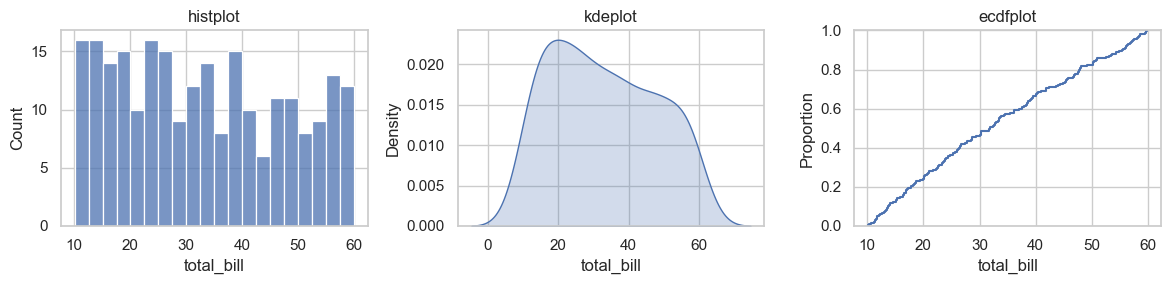

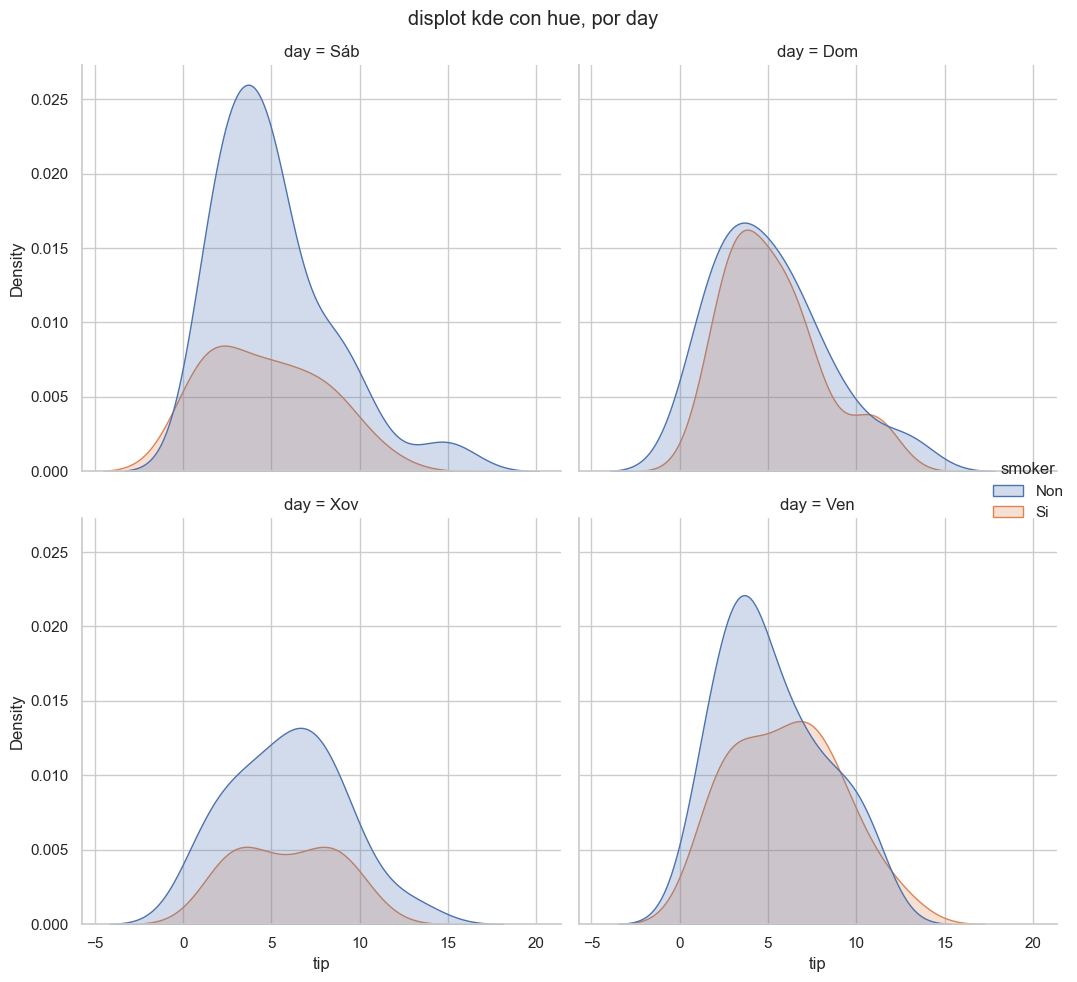

In [104]:
try:
    import seaborn as sns

    # Creamos unha figura con 3 subplots en fila
    fig, axs = plt.subplots(1,3, figsize=(12,3))

    # --- 1º subplot: histplot ---
    # Histograma de 'total_bill' con 20 intervalos (bins)
    sns.histplot(df_tips_like, x='total_bill', bins=20, ax=axs[0])
    axs[0].set_title('histplot')

    # --- 2º subplot: kdeplot ---
    # Estimación de densidade por Kernel (curva suave)
    # fill=True → enche a área baixo a curva
    sns.kdeplot(df_tips_like, x='total_bill', fill=True, ax=axs[1])
    axs[1].set_title('kdeplot')

    # --- 3º subplot: ecdfplot ---
    # Función de distribución acumulada empírica
    sns.ecdfplot(df_tips_like, x='total_bill', ax=axs[2])
    axs[2].set_title('ecdfplot')

    # Axustamos marges da figura
    plt.tight_layout()
    plt.show()

    # --- displot: interface de alto nivel ---
    # Distribución de 'tip' dividida por día (col='day'), dúas columnas por fila (col_wrap=2)
    # hue='smoker' → cor distinta para fumadores e non fumadores
    # kind='kde', fill=True → debuxa densidades suavizadas con área sombreada
    g = sns.displot(
        df_tips_like,
        x='tip',
        col='day',
        hue='smoker',
        kind='kde',
        fill=True,
        col_wrap=2
    )
    g.fig.suptitle('displot kde con hue, por day')
    plt.tight_layout()

except Exception as e:
    print('Seaborn non dispoñible:', e)



### 8.4. Gráficos para datos categóricos: `barplot`, `countplot`, `boxplot`, `violinplot`, `pointplot`

Os gráficos categóricos en Seaborn están deseñados para **comparar variables discretas (categóricas) con valores numéricos**, mostrando medias, distribucións ou frecuencias.

- **`barplot`**  
  - Mostra unha estimación da media dunha variable numérica para cada categoría.  
  - Por defecto amosa a media ± intervalo de confianza.  
  - Parámetros clave:  
    - `estimator` → función estatística (por defecto `mean`, pero pode ser `np.median`, `np.sum`, etc.).  
    - `ci` → nivel de confianza (por exemplo 95) ou `None` para desactivalo.  
    - `hue` → subdivide cada categoría en función doutra variable, con barras adxacentes.  
    - `orient` → `'v'` ou `'h'` para barras verticais ou horizontais.  

- **`countplot`**  
  - Conta o número de observacións en cada categoría (frecuencia absoluta).  
  - Útil para datos puramente cualitativos.  
  - Parámetros clave:  
    - `hue` → permite subdividir as contas por outra variable.  
    - `order` → especifica a orde das categorías.  
    - `palette` → paleta de cores personalizada.  

- **`boxplot`**  
  - Resume a distribución por categorías mediante cuartís, mediana, bigotes e outliers.  
  - Permite comparar variabilidade entre grupos.  
  - Parámetros clave:  
    - `hue` → engade unha segunda variable categórica para subdividir.  
    - `orient` → control da orientación.  
    - `width` → grosor da caixa.  
    - `whis` → extensión dos bigotes (ex. 1.5 × rango intercuartílico).  

- **`violinplot`**  
  - Variante que combina boxplot + estimación de densidade (mostra a forma da distribución).  
  - Útil para detectar multimodalidade.  
  - Parámetros clave:  
    - `split=True` → divide cada violín en dúas metades segundo `hue`.  
    - `inner` → controla elementos internos (`'box'`, `'quartile'`, `'point'`, ou `None`).  
    - `scale` → `'area'`, `'count'` ou `'width'` para normalizar os violíns.  

- **`pointplot`**  
  - Debuxa medias (ou outro estimador) por categoría e engade barras de erro.  
  - Representa puntos conectados por liñas → útil para mostrar evolución dunha medida por categorías ordenadas.  
  - Parámetros clave:  
    - `estimator`, `ci` → igual que en `barplot`.  
    - `join=True/False` → controla se os puntos se conectan con liña.  
    - `markers`, `linestyles` → estilo dos puntos e liñas.  

**Resumo**  
- `barplot` → compara **medias** por categorías (con erro).  
- `countplot` → mostra **frecuencias** absolutas.  
- `boxplot` → compara **distribucións resumidas**.  
- `violinplot` → visualiza **distribucións completas**.  
- `pointplot` → destaca **tendencias ou evolución** de medidas con barras de erro.  


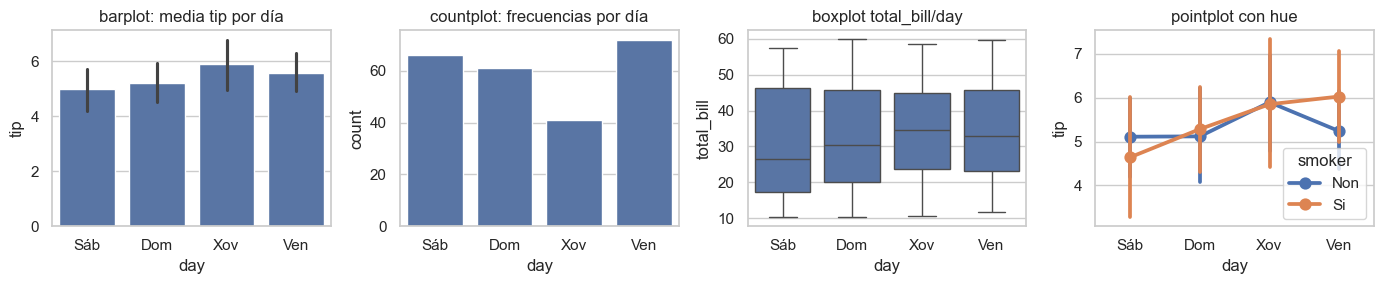

In [106]:
try:
    import seaborn as sns

    # Creamos unha figura con 4 subplots en fila (1x4)
    fig, axs = plt.subplots(1,4, figsize=(14,3))

    # --- 1º subplot: barplot ---
    # Calcula a media da propina (tip) por día da semana
    # estimator=np.mean → función estatística aplicada (por defecto xa é mean)
    sns.barplot(data=df_tips_like, x='day', y='tip', estimator=np.mean, ax=axs[0])
    axs[0].set_title('barplot: media tip por día')

    # --- 2º subplot: countplot ---
    # Conta directamente o número de rexistros por día (frecuencia absoluta)
    sns.countplot(data=df_tips_like, x='day', ax=axs[1])
    axs[1].set_title('countplot: frecuencias por día')

    # --- 3º subplot: boxplot ---
    # Mostra a distribución de 'total_bill' en función do día
    # Caixa → cuartís, liña → mediana, puntos → outliers
    sns.boxplot(data=df_tips_like, x='day', y='total_bill', ax=axs[2])
    axs[2].set_title('boxplot total_bill/day')

    # --- 4º subplot: pointplot ---
    # Representa a media de propina por día, diferenciando fumadores e non fumadores
    # hue='smoker' → cores distintas segundo a categoría
    # engade barras de erro (IC) e conecta puntos por defecto
    sns.pointplot(data=df_tips_like, x='day', y='tip', hue='smoker', ax=axs[3])
    axs[3].set_title('pointplot con hue')

    # Axustamos marges para que non se solapen etiquetas
    plt.tight_layout()
    plt.show()

except Exception as e:
    print('Seaborn non dispoñible:', e)



### 8.5. Matrices e agrupación: `heatmap`, `clustermap`, `pairplot`, `jointplot`, `FacetGrid`

Estes gráficos permiten **explorar relacións múltiples** entre variables e resumir información en matrices ou paneis de subplots.

- **`heatmap`**  
  - Representa unha matriz de valores como mapa de calor.  
  - Moi usado para visualizar **matrices de correlación** ou táboas cruzadas.  
  - Parámetros clave:  
    - `annot=True` → amosa os valores enriba de cada cela.  
    - `cmap` → mapa de cores (`'coolwarm'`, `'viridis'`…).  
    - `vmin`, `vmax` → fixan os límites da escala de cor.  
    - `linewidths`, `linecolor` → engaden liñas divisorias entre celas.  

- **`clustermap`**  
  - Variante de `heatmap` con **clustering jerárquico** en filas e columnas.  
  - Reordena automaticamente a matriz agrupando variables/observacións similares.  
  - Parámetros clave:  
    - `method` → método de linkage para clustering (`'average'`, `'complete'`, `'ward'`…).  
    - `metric` → métrica de distancia (`'euclidean'`, `'correlation'`…).  
    - `row_cluster`, `col_cluster` → permiten activar/desactivar clustering en filas/columnas.  
  - Útil para detectar patróns e grupos en datos complexos.  

- **`pairplot`**  
  - Debuxa unha **matriz de dispersións** para todas as combinacións de variables numéricas dun `DataFrame`.  
  - As diagonais poden mostrar histogramas ou KDEs individuais.  
  - Parámetros clave:  
    - `hue` → colorea os puntos segundo unha variable categórica.  
    - `kind` → tipo de gráfico nas off-diagonals (`'scatter'`, `'kde'`).  
    - `diag_kind` → tipo de gráfico na diagonal (`'hist'`, `'kde'`).  
    - `corner=True` → debuxa só a metade inferior (sen duplicados).  

- **`jointplot`**  
  - Mostra a relación entre dúas variables con gráficos marxináis.  
  - Parámetros clave:  
    - `kind` → `'scatter'`, `'kde'`, `'hist'`, `'reg'` (engade axuste lineal).  
    - `hue` → subdivisión por categoría.  
  - Útil para visualizar relación bivariante + distribucións individuais.  

- **`FacetGrid`**  
  - Obxecto base para facer **faceting** manual (repartir datos en múltiples subplots).  
  - Controla filas (`row`), columnas (`col`) e cores (`hue`).  
  - Úsase directamente ou a través de funcións de alto nivel como `catplot`, `relplot`, `displot`.  
  - Permite mapear calquera función de Seaborn ou Matplotlib a cada subconxunto de datos.  

**Resumo**  
- `heatmap` → visualización directa de matrices.  
- `clustermap` → engade clustering jerárquico para descubrir patróns.  
- `pairplot` → matriz de relacións múltiples entre variables numéricas.  
- `jointplot` → relación bivariante con distribucións marxináis.  
- `FacetGrid` → base para gráficos con *faceting*, clave para análise exploratoria multi-panel.  


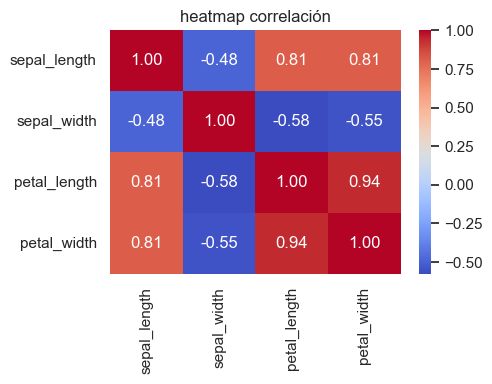

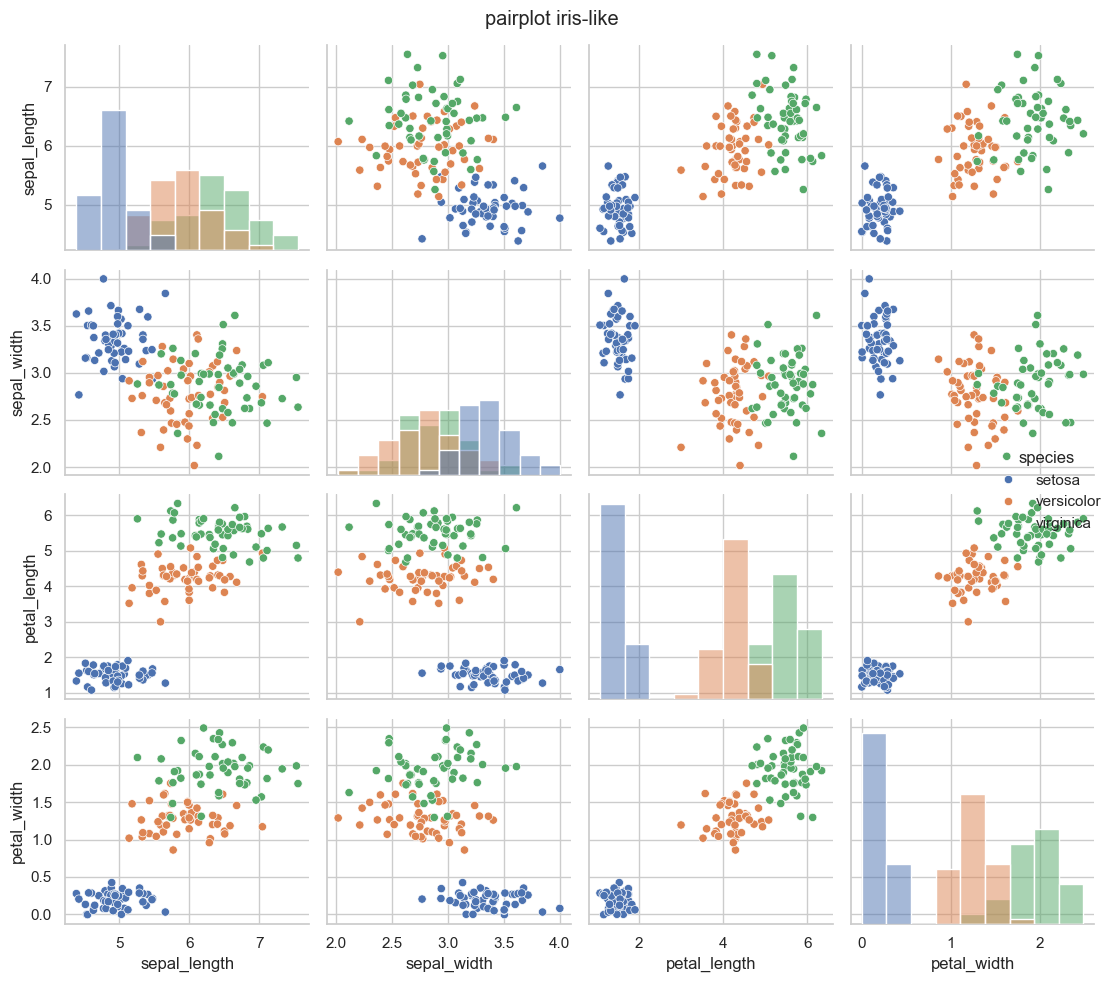

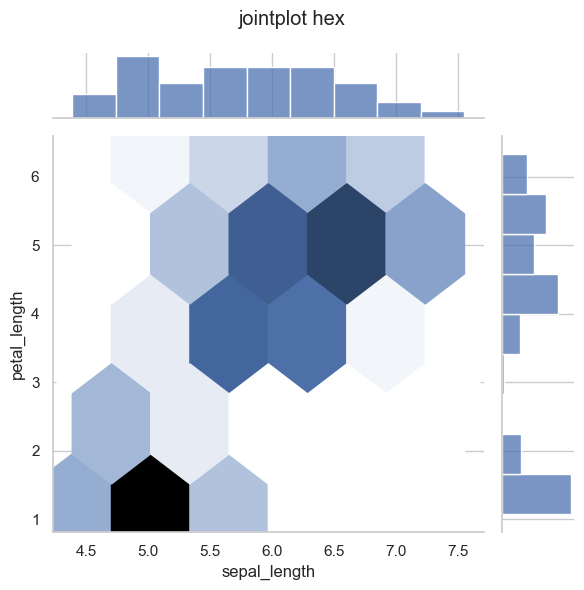

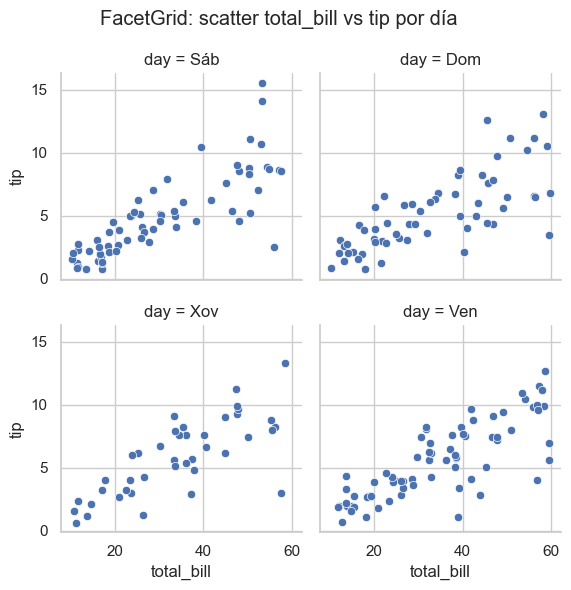

In [107]:
try:
    import seaborn as sns

    # --- Heatmap de correlación ---
    # Calculamos a correlación das variables numéricas do dataset iris_like
    corr = df_iris_like.drop(columns=['species']).corr(numeric_only=True)

    # Creamos a figura e debuxamos a matriz de correlación como mapa de calor
    fig, ax = plt.subplots(figsize=(5,4))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
    # annot=True → escribe os valores enriba de cada cela
    # fmt='.2f' → formata números con dúas decimais
    # cmap='coolwarm' → colormap diverxente
    ax.set_title('heatmap correlación')
    plt.tight_layout()
    plt.show()

    # --- Pairplot ---
    # Matriz de dispersións con todas as variables numéricas
    # hue='species' → colorea os puntos segundo a especie
    # diag_kind='hist' → na diagonal móstranse histogramas univariantes
    g = sns.pairplot(df_iris_like, hue='species', diag_kind='hist')
    g.fig.suptitle('pairplot iris-like')
    plt.tight_layout()

    # --- Jointplot ---
    # Relación entre sepal_length e petal_length
    # kind='hex' → usa hexágonos para visualizar densidade (útil en datos densos)
    g2 = sns.jointplot(data=df_iris_like, x='sepal_length', y='petal_length', kind='hex')
    g2.fig.suptitle('jointplot hex')
    plt.tight_layout()

    # --- FacetGrid manual ---
    # Creamos unha grella de subplots, un por día (col='day'), 2 columnas por fila
    g3 = sns.FacetGrid(df_tips_like, col='day', col_wrap=2)
    # Aplicamos un scatterplot a cada subconxunto
    g3.map_dataframe(sns.scatterplot, x='total_bill', y='tip')
    g3.fig.suptitle('FacetGrid: scatter total_bill vs tip por día')
    plt.tight_layout()

except Exception as e:
    print('Seaborn non dispoñible:', e)


## 9. Seaborn + Matplotlib: integración e afinado fino  {#sns-mpl}

Seaborn constrúese sobre Matplotlib, así que **todo o que debuxas con Seaborn está nun `Axes`/`Figure` de Matplotlib**. Isto permite combinar a **API de alto nivel** de Seaborn coa **personalización fina** de Matplotlib.

### Que devolve cada función
- Funccións base de Seaborn (ex. `scatterplot`, `lineplot`, `histplot`, `kdeplot`, `boxplot`, …) → devolven un **`matplotlib.axes.Axes`**.  
  - Podes aplicar: `ax.set(...)`, `ax.grid(...)`, `ax.legend(...)`, `ax.set_xlim/ylim`, `ax.set_title`, `ax.axhline/axvline`, `ax.annotate`, `ax.secondary_xaxis/yaxis`, etc.
- Funcións a nivel de figura (ex. `relplot`, `displot`, `catplot`, `lmplot`, `jointplot`, `pairplot`, `clustermap`) → devolven **obxectos contedor** (`FacetGrid`, `JointGrid`, `PairGrid`, `ClusterGrid`).
  - Neses casos: usa `g.axes` / `g.ax` / `g.fig` / `g.set_axis_labels()` / `g.add_legend()` / `g.set_titles()` para afinar.

### Personalización típica con `Axes`
- **Títulos e etiquetas**: `ax.set_title(...)`, `ax.set(xlabel='...', ylabel='...')`.
- **Límites/escala**: `ax.set_xlim/ylim`, `ax.set_xscale('log')`, `ax.set_yscale('symlog')`.
- **Ticks**: `ax.set_xticks/yticks`, `ax.set_xticklabels/yticklabels`, `ax.tick_params(...)`.
- **Grade/grella**: `ax.grid(True, linestyle=':')`.
- **Lendas**: `ax.legend(loc='best', ncol=2, frameon=True)`.
- **Spines**: `ax.spines['top'].set_visible(False)`, `ax.spines['left'].set_position(('outward', 10))`.
- **Eixes secundarios**: `ax.secondary_xaxis('top', functions=(fwd, inv))`, `ax.twinx()/twiny()`.

### Traballar con `FacetGrid` / `*Grid`
- **Acceso aos eixes**: `g.axes` (matriz de eixes) ou `g.ax` (algúns grids teñen un único eixo principal).
- **Etiquetas e títulos globais**: `g.set_axis_labels('X','Y')`, `g.set_titles(col_template='{col_name}', row_template='{row_name}')`, `g.fig.suptitle('Título xeral')`.
- **Lenda**: `g.add_legend()`.
- **Aparencia global**: `g.fig.tight_layout()` / `g.fig.subplots_adjust(top=...)` para deixar sitio ao `suptitle`.

### Estilo e temas: Seaborn vs Matplotlib
- **Seaborn**: `sns.set_theme(style=..., context=..., palette=...)` define **estética global** (grellas, fontes, paletas).
- **Matplotlib**: podes complementar coas `rcParams` ou `plt.rcParams.update({...})` para fontes, tamaños, grosor de liñas, etc.
- **Orde recomendada**: chama a `sns.set_theme(...)` ao comezar; logo axusta detalles con Matplotlib.

### Cores, colormaps e colorbars
- Cando Seaborn crea un mapeo de cor (ex. `hue` numérico con colormap), o artista resultante é un **mappable** de Matplotlib:
  - Podes engadir **colorbar** con `fig.colorbar(mappable, ax=ax)` (en gráficos que o soporten, p.ex. hexbin/kde de densidade, mapas de calor).
- Para **paletas cualitativas** (categóricas), usa `palette=` en Seaborn; para **colormaps secuenciais/diverxentes**, é habitual usar colormaps de Matplotlib (`'viridis'`, `'coolwarm'`, …).

### Layout e composición
- Seaborn xestiona as súas figuras, pero **`tight_layout()`/`constrained_layout=True`** seguen sendo útiles para evitar solapamentos.
- Para composicións complexas: crea a figura e os `Axes` con Matplotlib (`plt.subplots`, `GridSpec`) e pasa **`ax=`** ás chamadas de Seaborn para debuxar exactamente onde queiras.

### Consellos prácticos
- **Reutiliza `ax=`**: crea a grella con Matplotlib e chama a Seaborn pasando `ax=...` en cada pane.
- **Post-procesado fino**: aplica cambios de Matplotlib **despois** de debuxar con Seaborn (títulos, límites, anotacións, spines, lendas personalizadas).
- **Coherencia visual**: establece o tema de Seaborn unha vez e evita mesturar demasiadas fontes/estilos; remata axustando coas ferramentas de Matplotlib.

**Resumo**  
- Seaborn dáche **sinxeleza e potencia estatística**; Matplotlib ofréceche o **control milimétrico**.  
- Traballa en Seaborn para **declarar o gráfico**, e remata en Matplotlib para **pulir**: límites, ticks, spines, lendas, anotacións, eixes secundarios e layout.


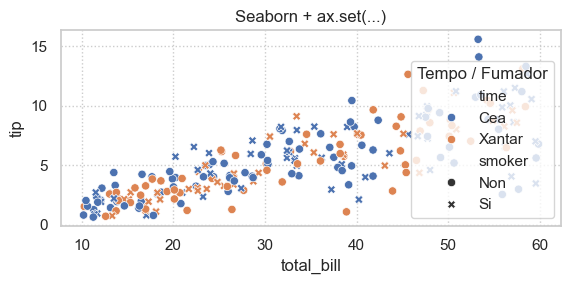

In [108]:
try:
    import seaborn as sns

    # Creamos unha figura e un eixo
    fig, ax = plt.subplots(figsize=(6,3))

    # --- Gráfico principal con Seaborn ---
    # scatterplot de total_bill vs tip
    # - hue='time' → cores diferentes segundo se foi "Lunch" ou "Dinner"
    # - style='smoker' → marcador diferente para fumadores e non fumadores
    sns.scatterplot(
        data=df_tips_like,
        x='total_bill', y='tip',
        hue='time', style='smoker',
        ax=ax
    )

    # --- Personalización con Matplotlib ---
    # Título e grade
    ax.set_title('Seaborn + ax.set(...)')
    ax.grid(True, linestyle=':')  # engadimos grella con liñas de puntos

    # Lenda personalizada
    ax.legend(
        title='Tempo / Fumador',   # título da lenda
        loc='lower right'          # posición no gráfico
    )

    # Axustamos a disposición para evitar solapamentos
    fig.tight_layout()
    plt.show()

except Exception as e:
    print('Seaborn non dispoñible:', e)


## 10. Exportación, formatos e boas prácticas  {#export}

**Exportar figuras**

- `plt.savefig('fig.png', dpi=300, bbox_inches='tight')`  
  - `dpi=300` → resolución axeitada para impresión ou publicación.  
  - `bbox_inches='tight'` → recorta automaticamente marxes en branco innecesarias.  
- **Formatos**:  
  - **`PNG`** → imaxe raster, boa para web e informes rápidos.  
  - **`SVG` / `PDF`** → formatos vectoriais, recomendados para publicacións e impresión porque non perden calidade ao escalar.  
  - **`JPG`** → pouco recomendable para gráficos (compresión con perdas).  
- Pódese gardar directamente en alta resolución para artigos, posters ou presentacións.  
- Recoméndase usar nomes de ficheiro claros e, se é necesario, engadir versión ou data (`analise_vendas_2025-01.png`).  

---

**Boas prácticas de visualización (resumo)**

- **Usa a API orientada a obxectos (OO)** → garante reproducibilidade, facilita a composición de varias figuras e é máis clara que a interface global (`plt.plot`).  
- **Etiquetas claras e unidades** → sempre indicar que representan os eixes e en que unidade (€, %, s, cm...).  
  - Se hai números ou datas, empregar `matplotlib.ticker.Formatter` ou `DateFormatter` para mellorar a lexibilidade.  
- **Mantén coherencia de escalas** cando compares varias gráficas (mesma unidade, mesmo rango cando teña sentido).  
- **Cores e paletas**  
  - Evitar o abuso de cores intensas ou moi similares.  
  - Preferir paletas accesibles (compatibles con daltonismo, ex. `sns.color_palette("colorblind")` ou `viridis`).  
- **Documentación visual**  
  - Inclúe un **título curto e informativo**.  
  - Se procede, engade **pé de figura ou anotacións** para destacar valores clave ou advertir sobre limitacións dos datos.  
- **Claridade sobre estética**  
  - As gráficas son ferramentas de comunicación: evita decoración excesiva ou elementos redundantes.  
  - Favorece grellas discretas, fontes lexibles e tamaños adaptados ao contexto (artigo, presentación, póster).  



Gardadas: exemplo_export_detallado.png, exemplo_export_detallado.svg


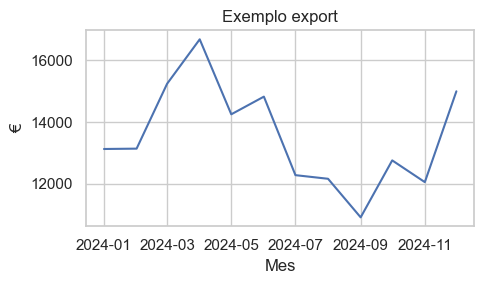

In [110]:
# Creamos unha figura e un eixe cun tamaño 5x3
fig, ax = plt.subplots(figsize=(5,3))

# Debuxamos a serie de vendas para a categoría "Ropa"
ax.plot(
    df_vendas[df_vendas['categoria']=='Ropa']['mes'],
    df_vendas[df_vendas['categoria']=='Ropa']['vendas']
)

# Engadimos título e etiquetas de eixes
ax.set(title='Exemplo export', xlabel='Mes', ylabel='€')

# Axustamos os marges para evitar solapamentos
fig.tight_layout()

# --- Exportación en distintos formatos ---

# PNG → formato raster a 300 dpi, con marxes recortadas
fig.savefig('out/exemplo_export_detallado.png', dpi=300, bbox_inches='tight')

# SVG → formato vectorial, útil para impresión ou edición posterior
fig.savefig('out/exemplo_export_detallado.svg', bbox_inches='tight')

print('Gardadas: exemplo_export_detallado.png, exemplo_export_detallado.svg')


## 11. Referencias e notas de datasets  {#refs}
**Documentación oficial**
- Matplotlib: https://matplotlib.org/stable/
- Seaborn: https://seaborn.pydata.org/

**Datasets (orixe conceptual)**
- *Iris* — Fisher, R. A. (1936). "The use of multiple measurements in taxonomic problems". (
  No caderno empregarase un **dataset sintético inspirado** no Iris orixinal; non se inclúen datos reais.)
- *Tips* — Dataset de exemplo popularizado por Seaborn para demostracións de gráficos categóricos (
  aquí emprégase unha **simulación sintética** semellante).

**Nota**: a variabilidade dos gráficos depende da semente aleatoria (`rng = default_rng(...)`).
